In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from tqdm import tqdm

In [2]:
df = pd.read_csv('resampled_cluster_cpu_util.csv')

In [3]:
df.head()

machine_id                 time  cpu_util
0        m29  2017-10-03 00:00:00  7.945417
1        m29  2017-10-03 01:00:00  8.439750
2        m29  2017-10-03 02:00:00  8.421444
3        m29  2017-10-03 03:00:00  8.465806
4        m29  2017-10-03 04:00:00  8.457917

In [4]:
df.describe()

cpu_util
count  1633.000000
mean     15.070595
std      12.554680
min       0.000000
25%       7.541306
50%       8.336972
75%      28.066861
max      53.302389

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1771 entries, 0 to 1770
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   machine_id  1771 non-null   object 
 1   time        1771 non-null   object 
 2   cpu_util    1633 non-null   float64
dtypes: float64(1), object(2)
memory usage: 41.6+ KB


In [6]:
# Convert time column to datetime objects
df['time'] = pd.to_datetime(df['time'], format='mixed')

# Create a new column for float timestamps
df['timestamp_float'] = df['time'].apply(lambda x: x.timestamp())

# sort by time
df.sort_values(by='time', inplace=True)

In [7]:
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
df['machine_id'] = le.fit_transform(df['machine_id'])

In [8]:
#remove the missing values
df = df.dropna()

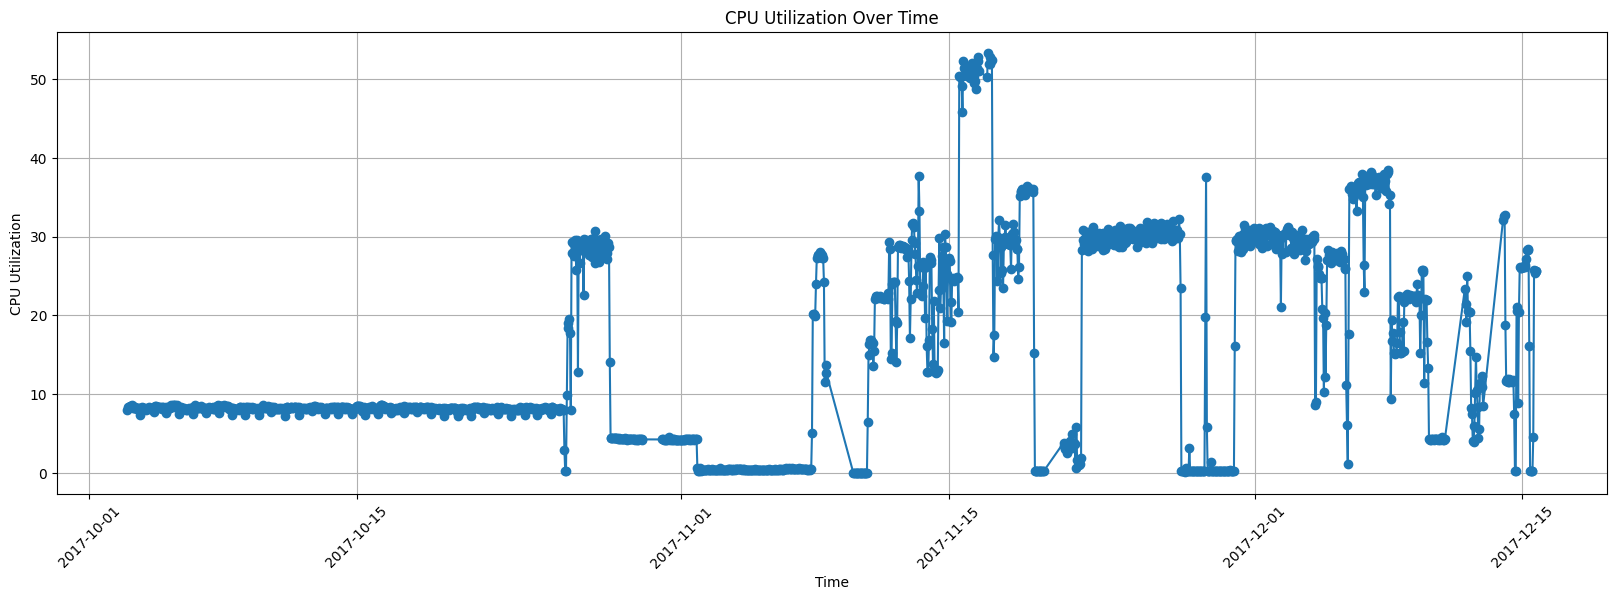

In [9]:
plt.figure(figsize=(20, 6))
plt.plot(df['time'], df['cpu_util'], marker='o')
plt.xlabel('Time')
plt.ylabel('CPU Utilization')
plt.title('CPU Utilization Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Aggregated Trends

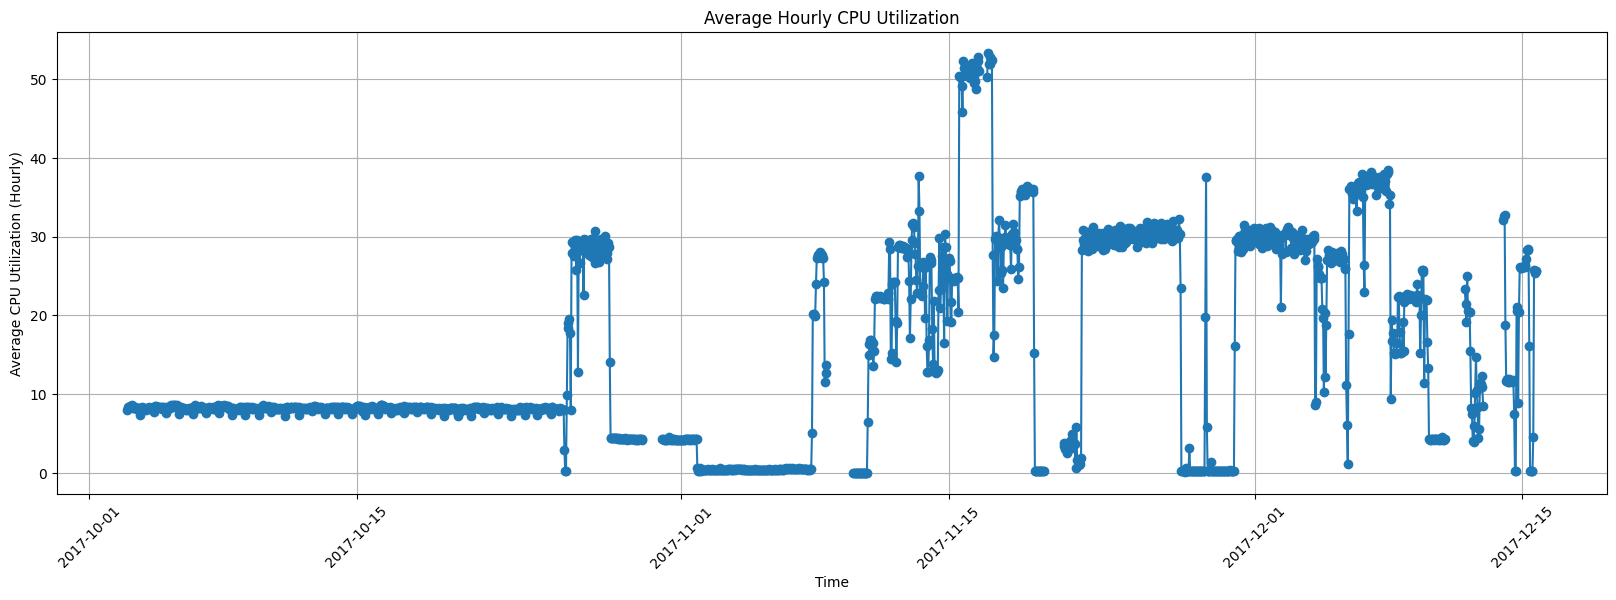

In [10]:
hourly_avg = df.resample('H', on='time').mean()

plt.figure(figsize=(20, 6))
plt.plot(hourly_avg.index, hourly_avg['cpu_util'], marker='o')
plt.xlabel('Time')
plt.ylabel('Average CPU Utilization (Hourly)')
plt.title('Average Hourly CPU Utilization')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Machine-wise Analysis

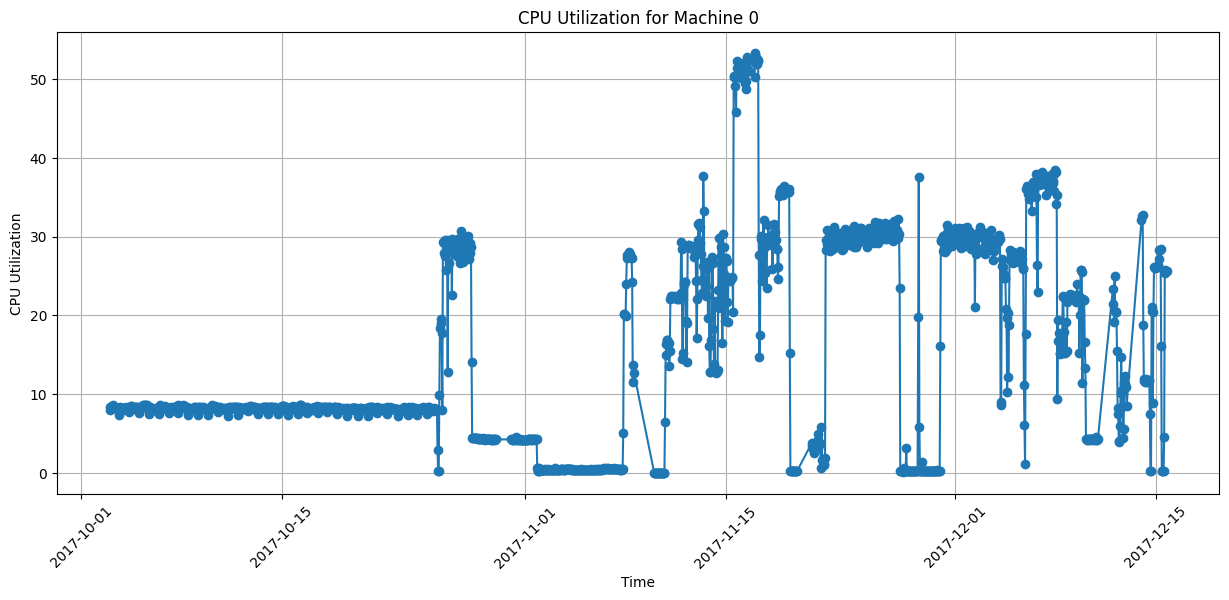

In [11]:
unique_machines = df['machine_id'].unique()

for machine in unique_machines:
    machine_data = df[df['machine_id'] == machine]
    plt.figure(figsize=(15, 6))
    plt.plot(machine_data['time'], machine_data['cpu_util'], marker='o')
    plt.xlabel('Time')
    plt.ylabel('CPU Utilization')
    plt.title(f'CPU Utilization for Machine {machine}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

### Rolling window

In [ ]:
window_size = 24  # Adjust this based on your desired window size

mean_cpu_util = df['cpu_util'].mean()
df['moving_avg'] = np.nan
# fill nan values with mean
df['cpu_util'] = df['cpu_util'].fillna(mean_cpu_util)
df['moving_avg'] = df['cpu_util'].rolling(window=window_size).mean()

plt.figure(figsize=(15, 4))
plt.plot(df['time'], df['cpu_util'], label='CPU Utilization')
plt.plot(df['time'], df['moving_avg'], label=f'Simple Moving Avg (Window={window_size})')
plt.xlabel('Time')
plt.ylabel('CPU Utilization')
plt.title('CPU Utilization and Simple Moving Average')
plt.legend()
plt.grid(True)
plt.show()

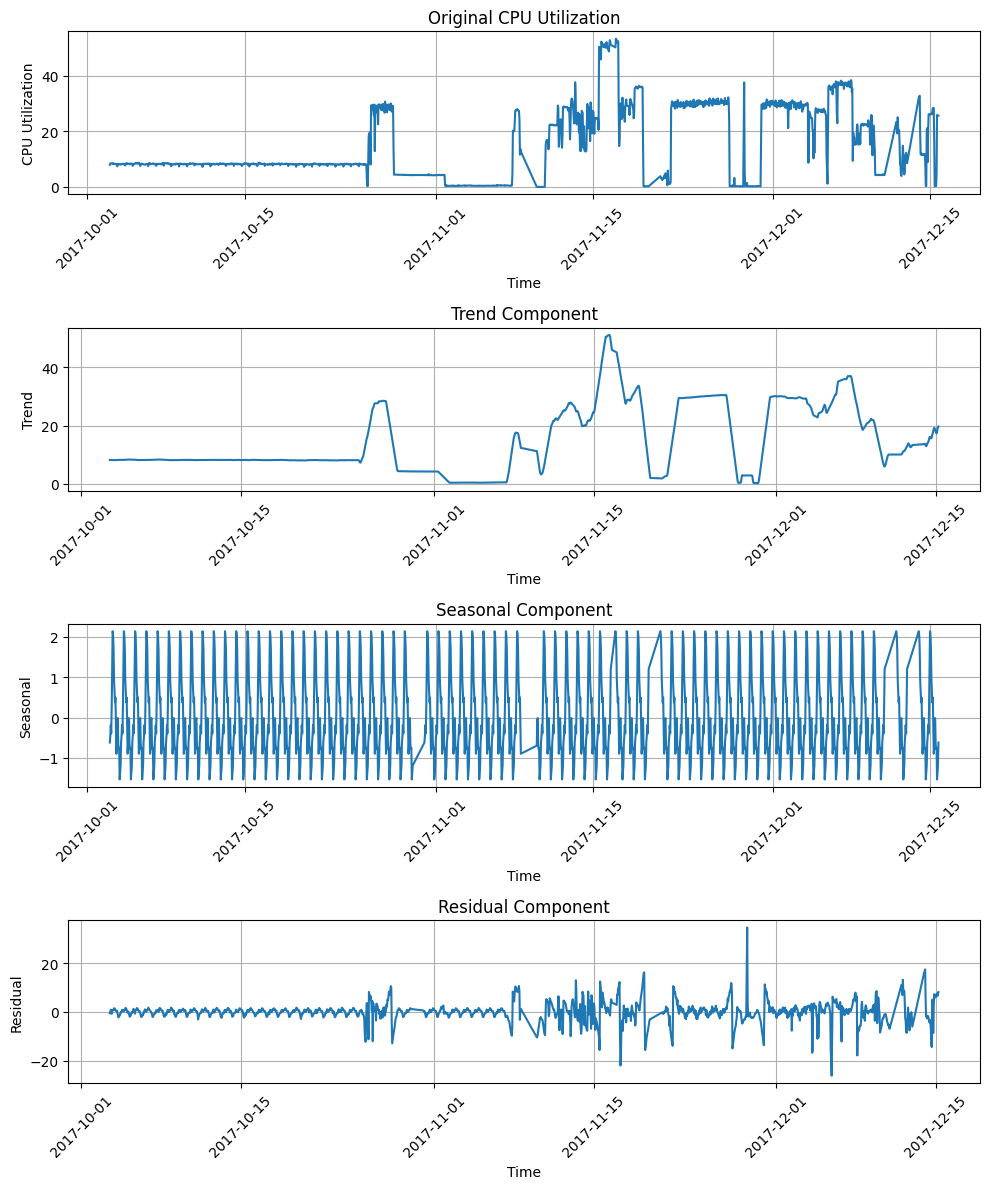

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['cpu_util'], period=24)  # Assuming df is recorded every minute (24 * 60 minutes)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(df['time'], df['cpu_util'], label='Original')
plt.xlabel('Time')
plt.ylabel('CPU Utilization')
plt.title('Original CPU Utilization')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(df['time'], trend, label='Trend')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.title('Trend Component')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(df['time'], seasonal, label='Seasonal')
plt.xlabel('Time')
plt.ylabel('Seasonal')
plt.title('Seasonal Component')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(df['time'], residual, label='Residual')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Residual Component')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# loop 1 to 12 to see the lag plot in grid 4x3
plt.figure(figsize=(15, 15))
for i in range(1, 13):
    plt.subplot(4, 3, i)
    plt.scatter(df['cpu_util'], df['cpu_util'].shift(i), alpha=0.5)
    plt.xlabel('CPU Utilization (t)')
    plt.ylabel(f'CPU Utilization (t - {i})')
    plt.title(f'Lag Plot (lag = {i})')
    plt.grid(True)
plt.tight_layout()
plt.show()


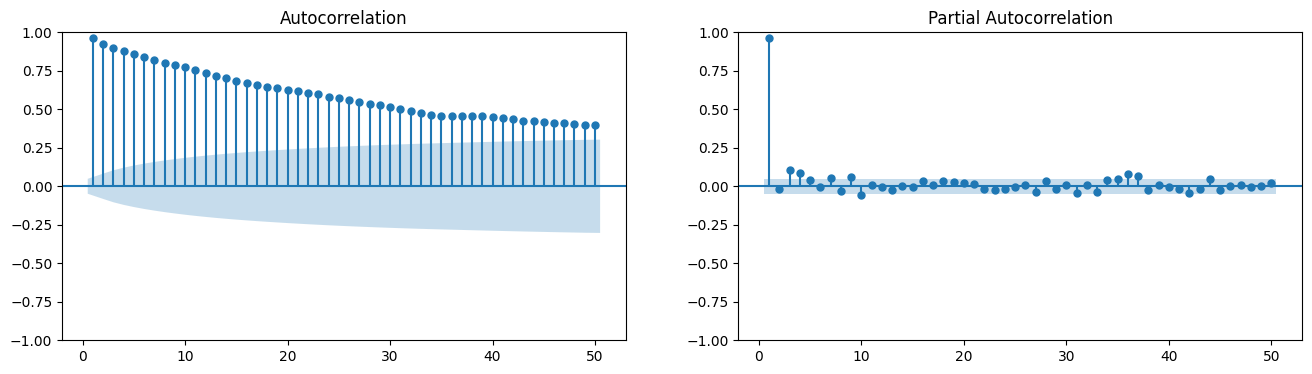

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 1x2 grid for ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
# ACF plot
plot_acf(df['cpu_util'], lags=50, zero=False, ax=ax1)
# PACF plot
plot_pacf(df['cpu_util'], lags=50, zero=False, ax=ax2)
plt.show()

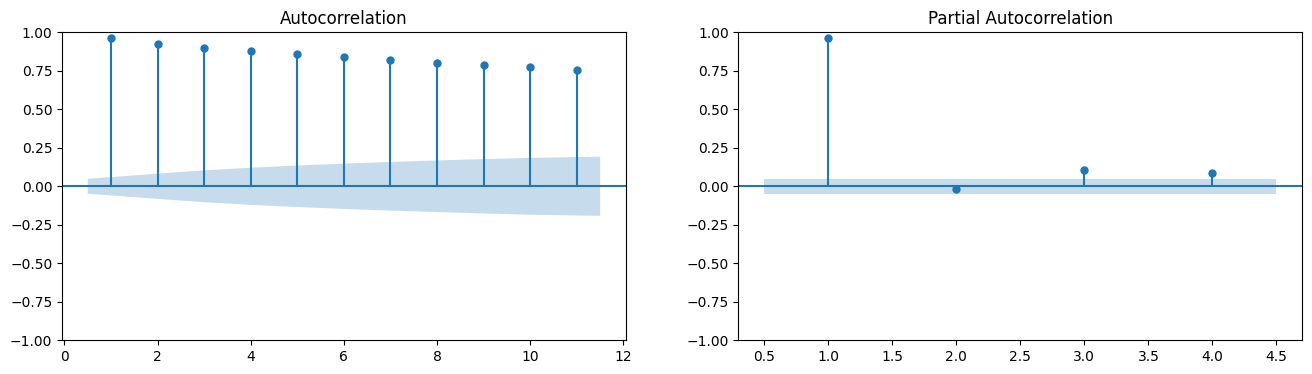

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 1x2 grid for ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
# ACF plot
plot_acf(df['cpu_util'], lags=11, zero=False, ax=ax1)
# PACF plot
plot_pacf(df['cpu_util'], lags=4, zero=False, ax=ax2)
plt.show()

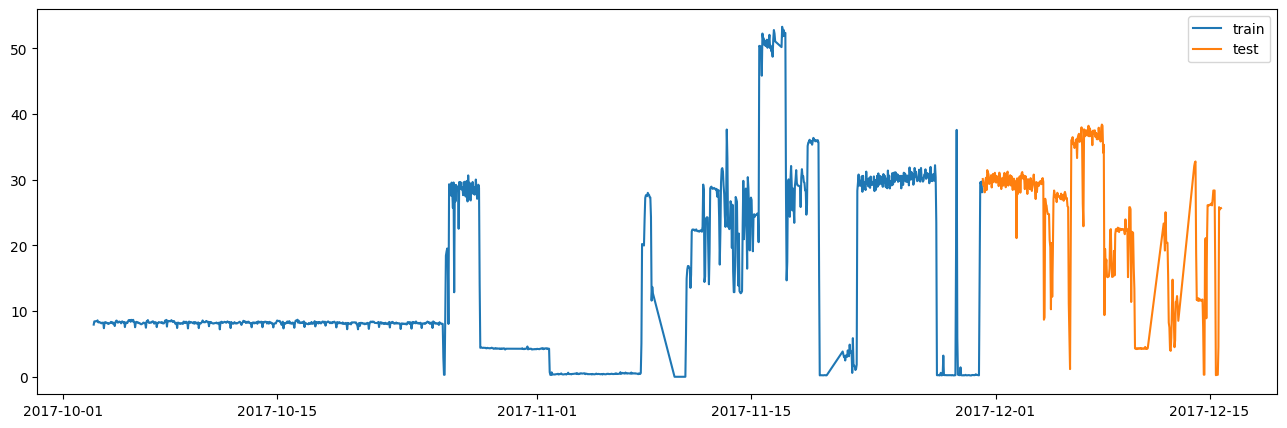

In [17]:
# rename the cpu_util column to target
df.rename(columns={'cpu_util': 'target'}, inplace=True)
# convert the categorical data of column 'machine_id' to numerical data

# split the data into train and test sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]


# plot train and test data
plt.figure(figsize=(16, 5))
plt.plot(train['time'], train['target'], label='train')
plt.plot(test['time'], test['target'], label='test')
plt.legend(loc='best')
plt.show()

In [18]:
train.head()

machine_id                time    target  timestamp_float  moving_avg
0           0 2017-10-03 00:00:00  7.945417     1.506989e+09         NaN
1           0 2017-10-03 01:00:00  8.439750     1.506992e+09         NaN
2           0 2017-10-03 02:00:00  8.421444     1.506996e+09         NaN
3           0 2017-10-03 03:00:00  8.465806     1.507000e+09         NaN
4           0 2017-10-03 04:00:00  8.457917     1.507003e+09         NaN

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load your dataset
data = pd.read_csv('resampled_cluster_cpu_util.csv')

# Preprocess the data
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data.dropna(subset=['cpu_util'], inplace=True)


# Train-test split
train_size = int(0.8 * len(data))
train, test = data[:train_size], data[train_size:]



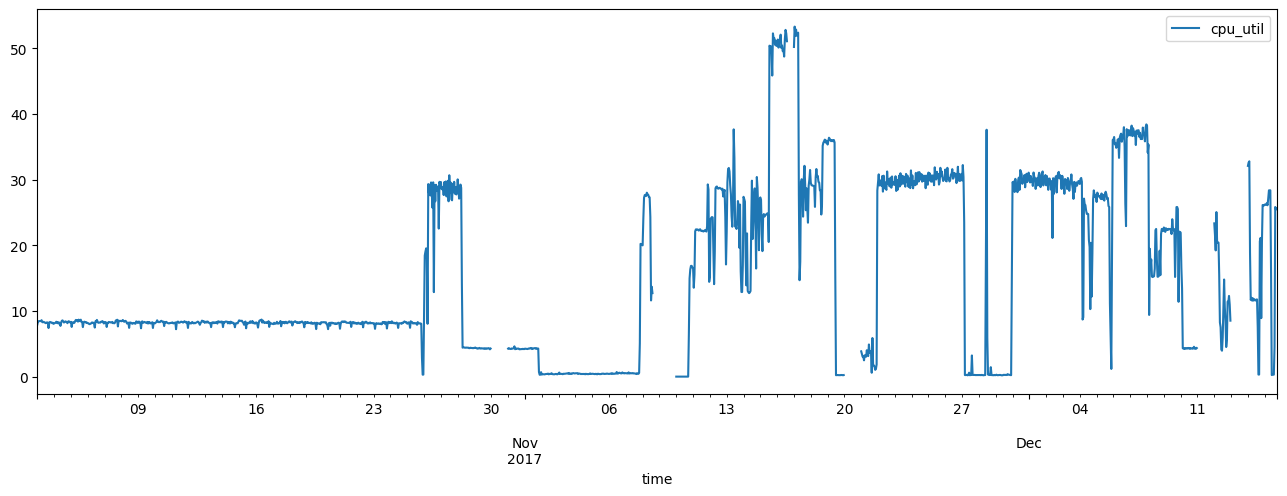

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load your dataset
data = pd.read_csv('resampled_cluster_cpu_util.csv')

# Preprocess the data
data['time'] = pd.to_datetime(data['time'])

# plot the data
data.plot(x='time', y='cpu_util', figsize=(16,5))
plt.show()


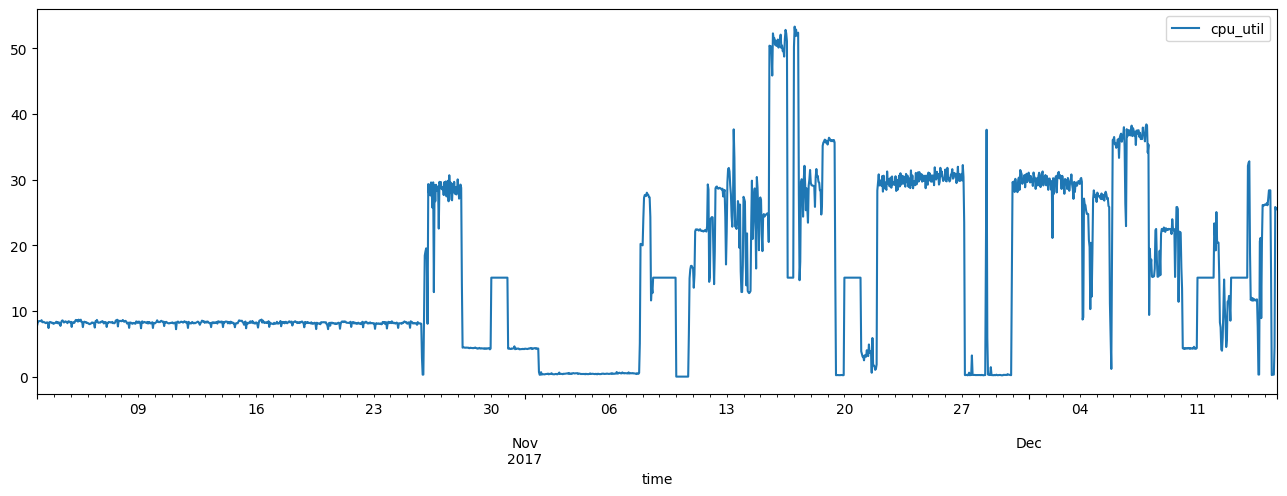

In [41]:
# fill the missing values with the mean
data['cpu_util'] = data['cpu_util'].fillna(data['cpu_util'].mean())

# plot the data
data.plot(x='time', y='cpu_util', figsize=(16,5))
plt.show()

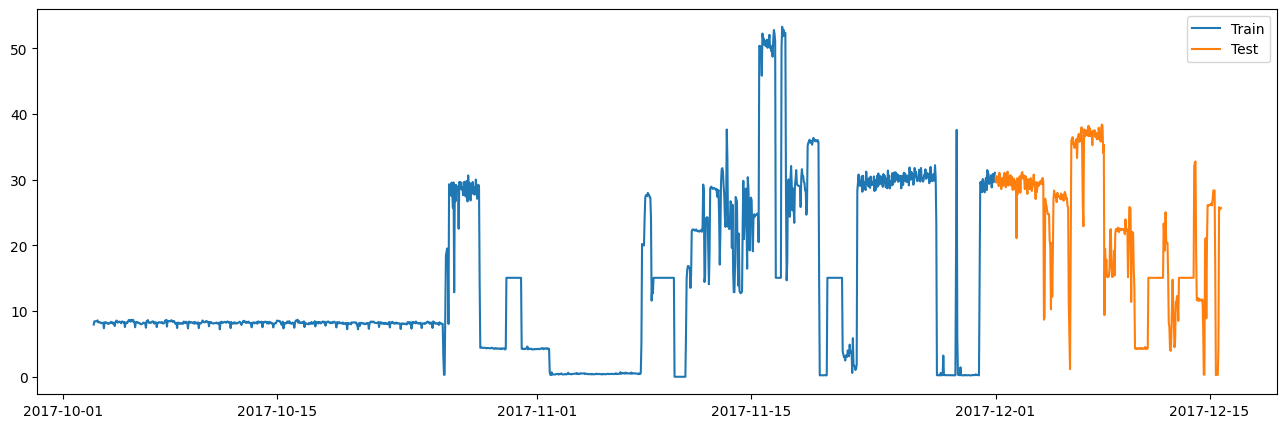

In [43]:
# split the data into train and test 80/20
train = data.iloc[:int(0.8*len(data))]
test = data.iloc[int(0.8*len(data)):]

# plot the train and test data
plt.figure(figsize=(16,5))
plt.plot(train['time'], train['cpu_util'], label='Train')
plt.plot(test['time'], test['cpu_util'], label='Test')
plt.legend(loc='best')
plt.show()

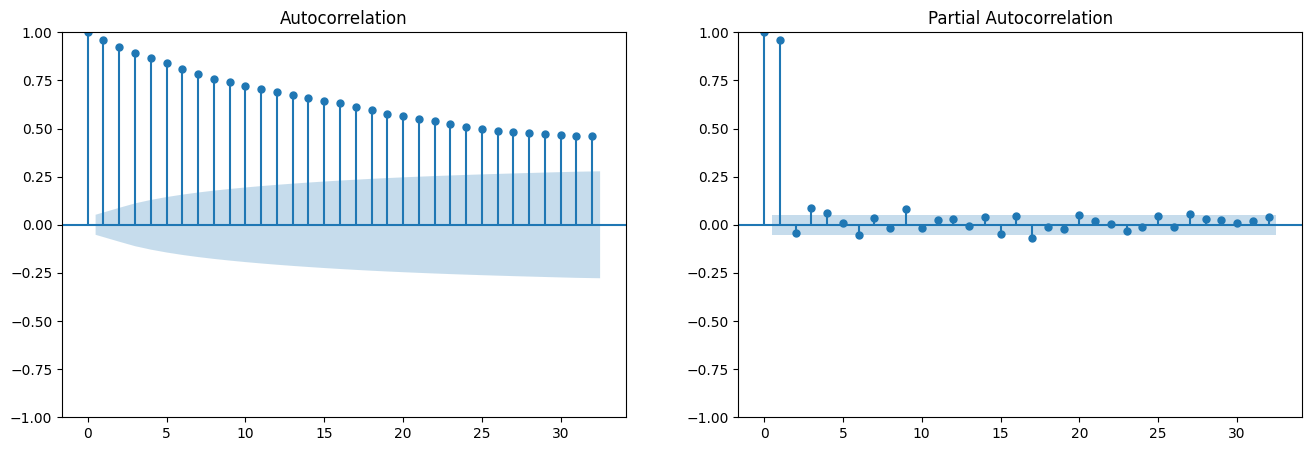

In [45]:
# plot the autocorrelation and partial autocorrelation side by side
fig, ax = plt.subplots(1,2, figsize=(16,5))
plot_acf(train['cpu_util'], ax=ax[0])
plot_pacf(train['cpu_util'], ax=ax[1])
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69529D+00    |proj g|=  9.65932D-02


 This problem is unconstrained.



At iterate    5    f=  2.57814D+00    |proj g|=  1.47110D-02

At iterate   10    f=  2.56960D+00    |proj g|=  2.19259D-03

At iterate   15    f=  2.56851D+00    |proj g|=  6.86388D-03

At iterate   20    f=  2.56797D+00    |proj g|=  8.78972D-03

At iterate   25    f=  2.56778D+00    |proj g|=  4.30477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     31      1     0     0   3.224D-06   2.568D+00
  F =   2.5677734950173594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


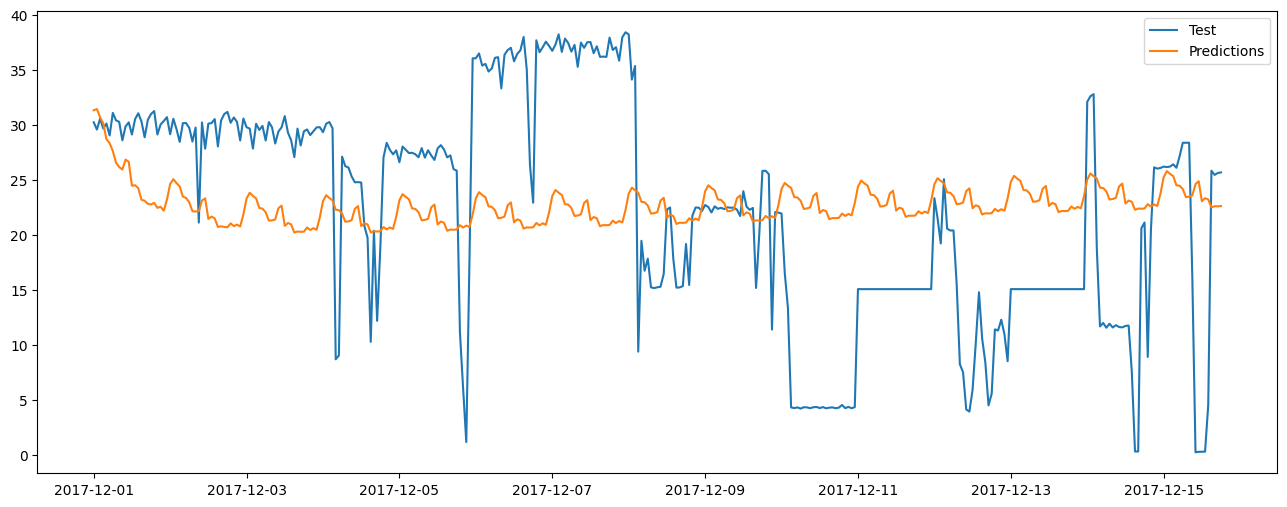

In [53]:

# fit the model
model = SARIMAX(train['cpu_util'], order=(1,1,1), seasonal_order=(1,1,1,24))
results = model.fit()

# get the predictions and residuals
predictions = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
residuals = test['cpu_util'] - predictions

# plot the predictions and residuals
plt.figure(figsize=(16,6))
# plt.plot(train['time'], train['cpu_util'], label='Train')
plt.plot(test['time'], test['cpu_util'], label='Test')
plt.plot(test['time'], predictions, label='Predictions')
plt.legend(loc='best')
plt.show()

In [48]:
# evaluate the model
print('Mean Absolute Percentage Error: ', np.mean(np.abs(residuals/test['cpu_util']))*100)
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals**2)))
print('Mean Absolute Error: ', np.mean(np.abs(residuals)))


Mean Absolute Percentage Error:  204.66915549898678
Root Mean Squared Error:  10.212491958204948
Mean Absolute Error:  8.635426484972488


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29485D+00    |proj g|=  3.17080D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.171D-08   4.295D+00
  F =   4.2948531342446321     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.03414D+00    |proj g|=  8.28214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     12      1     0     0   4.398D-07   4.031D+00
  F =   4.0314574117340412     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80451D+00    |proj g|=  1.47346D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73768D+00    |proj g|=  5.49076D-02


 This problem is unconstrained.



At iterate    5    f=  3.72087D+00    |proj g|=  2.92184D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      9      1     0     0   2.621D-07   3.721D+00
  F =   3.7208670933888941     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82577D+00    |proj g|=  6.51397D-03


 This problem is unconstrained.



At iterate    5    f=  3.82554D+00    |proj g|=  1.43663D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   1.437D-07   3.826D+00
  F =   3.8255449743294441     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81100D+00    |proj g|=  8.59086D-02


 This problem is unconstrained.



At iterate    5    f=  3.78380D+00    |proj g|=  2.90540D-02

At iterate   10    f=  3.77942D+00    |proj g|=  9.21111D-04

At iterate   15    f=  3.77939D+00    |proj g|=  6.77680D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   6.777D-07   3.779D+00
  F =   3.7793929466797591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76505D+00    |proj g|=  4.80573D-03


 This problem is unconstrained.



At iterate    5    f=  3.76498D+00    |proj g|=  4.03202D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   1.755D-06   3.765D+00
  F =   3.7649592108660510     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75762D+00    |proj g|=  7.32727D-02


 This problem is unconstrained.



At iterate    5    f=  3.70540D+00    |proj g|=  5.84604D-02

At iterate   10    f=  3.68693D+00    |proj g|=  2.93917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   2.950D-07   3.687D+00
  F =   3.6868987978491532     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29512D+00    |proj g|=  1.01460D+00

At iterate    5    f=  3.79110D+00    |proj g|=  4.62017D-02

At iterate   10    f=  3.71196D+00    |proj g|=  2.00861D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     15      1     0     0   2.940D-07   3.712D+00
  F =   3.7118566647873990     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51812D+00    |proj g|=  3.94965D-02


 This problem is unconstrained.



At iterate    5    f=  3.25659D+00    |proj g|=  5.15607D-02

At iterate   10    f=  3.23991D+00    |proj g|=  2.14913D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     18      1     0     0   4.380D-06   3.240D+00
  F =   3.2399054635609716     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98602D+00    |proj g|=  3.67405D-01

At iterate    5    f=  3.51016D+00    |proj g|=  2.37425D-02

At iterate   10    f=  3.43105D+00    |proj g|=  4.88939D-02

At iterate   15    f=  3.35751D+00    |proj g|=  2.17143D-02

At iterate   20    f=  3.35455D+00    |proj g|=  8.06670D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     39      1     0     0   8.067D-06   3.355D+00
  F =   3.3545504574317171     

CONVERG

/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97753D+00    |proj g|=  3.64657D-01


 This problem is unconstrained.



At iterate    5    f=  3.51077D+00    |proj g|=  9.08967D-02

At iterate   10    f=  3.34321D+00    |proj g|=  7.65674D-02

At iterate   15    f=  3.29102D+00    |proj g|=  4.53479D-03

At iterate   20    f=  3.29037D+00    |proj g|=  6.22458D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   6.225D-06   3.290D+00
  F =   3.2903675194817743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54116D+00    |proj g|=  4.05608D-02

At iterate    5    f=  3.33502D+00    |proj g|=  1.07425D-01

At iterate   10    f=  3.30285D+00    |proj g|=  2.85998D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     19      1     0     0   1.355D-05   3.303D+00
  F =   3.3028471909290724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  3.34419D+00    |proj g|=  4.21752D-02

At iterate   10    f=  3.21480D+00    |proj g|=  3.15913D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     24      1     0     0   1.440D-06   3.215D+00
  F =   3.2147660451427407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86670D+00    |proj g|=  4.65229D-02

At iterate    5    f=  3.36108D+00    |proj g|=  3.04476D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84757D+00    |proj g|=  9.32881D-02


 This problem is unconstrained.



At iterate    5    f=  3.42323D+00    |proj g|=  2.48804D-01

At iterate   10    f=  3.22392D+00    |proj g|=  1.12870D-02

At iterate   15    f=  3.22367D+00    |proj g|=  1.56222D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     26      1     0     0   1.562D-06   3.224D+00
  F =   3.2236744837588795     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39344D+00    |proj g|=  1.86445D-01


 This problem is unconstrained.



At iterate    5    f=  3.29933D+00    |proj g|=  2.22247D-01

At iterate   10    f=  3.15438D+00    |proj g|=  4.89938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   1.887D-06   3.154D+00
  F =   3.1542303217188752     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34256D+00    |proj g|=  8.78660D-02

At iterate    5    f=  3.07448D+00    |proj g|=  6.27741D-02

At iterate   10    f=  2.98896D+00    |proj g|=  3.85103D-02

At iterate   15    f=  2.98644D+00    |proj g|=  2.03713D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     24      1     0     0   1.417D-05   2.986D+00
  F =   2.9864423611099822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  3.69305D+00    |proj g|=  1.25371D-01

At iterate   10    f=  3.35732D+00    |proj g|=  8.28772D-01

At iterate   15    f=  3.14223D+00    |proj g|=  1.05771D-01

At iterate   20    f=  3.12270D+00    |proj g|=  5.95988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   2.755D-06   3.123D+00
  F =   3.1226977230398814     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  3.62928D+00    |proj g|=  2.21513D-01

At iterate   10    f=  3.05479D+00    |proj g|=  1.21161D-01

At iterate   15    f=  3.03288D+00    |proj g|=  3.92679D-04

At iterate   20    f=  3.03286D+00    |proj g|=  3.86431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   3.430D-06   3.033D+00
  F =   3.0328591334130368     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  3.21726D+00    |proj g|=  2.54145D-01

At iterate   10    f=  3.07364D+00    |proj g|=  3.46872D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     20      1     0     0   9.078D-06   3.073D+00
  F =   3.0725328905856215     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35234D+00    |proj g|=  9.72846D-02


 This problem is unconstrained.



At iterate    5    f=  3.14936D+00    |proj g|=  2.09991D-01

At iterate   10    f=  2.97764D+00    |proj g|=  4.23145D-02

At iterate   15    f=  2.97535D+00    |proj g|=  6.53422D-03

At iterate   20    f=  2.97518D+00    |proj g|=  5.94982D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     27      1     0     0   5.950D-06   2.975D+00
  F =   2.9751776465536710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   2.517D-06   2.586D+00
  F =   2.5864207896676654     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91548D+00    |proj g|=  3.78469D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61655D+00    |proj g|=  4.95997D-02

At iterate    5    f=  2.57852D+00    |proj g|=  2.67275D-03

At iterate   10    f=  2.57745D+00    |proj g|=  6.13105D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     15      1     0     0   4.077D-06   2.577D+00
  F =   2.5774459974193960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   2.447D-08   2.587D+00
  F =   2.5865268214190302     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58694D+00    |proj g|=  1.50097D-02


 This problem is unconstrained.



At iterate    5    f=  2.58625D+00    |proj g|=  7.12591D-04

At iterate   10    f=  2.58619D+00    |proj g|=  1.72678D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   7.097D-07   2.586D+00
  F =   2.5861864998805819     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76978D+00    |proj g|=  7.43397D-03


 This problem is unconstrained.



At iterate    5    f=  2.76966D+00    |proj g|=  6.02602D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   6.026D-06   2.770D+00
  F =   2.7696601011358117     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62567D+00    |proj g|=  7.70889D-02

At iterate    5    f=  2.57977D+00    |proj g|=  1.09298D-02

At iterate   10    f=  2.57534D+00    |proj g|=  5.49809D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   5.112D-06   2.575D+00
  F =   2.5753083039850790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58768D+00    |proj g|=  9.54000D-03

At iterate    5    f=  2.58762D+00    |proj g|=  2.95910D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   2.959D-06   2.588D+00
  F =   2.5876206742778547     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  2.58598D+00    |proj g|=  1.71631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.716D-04   2.586D+00
  F =   2.5859755790791947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91542D+00    |proj g|=  5.47264D-03

At iterate    5    f=  2.91540D+00    |proj g|=  3.77103D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69124D+00    |proj g|=  9.97985D-02

At iterate    5    f=  2.58476D+00    |proj g|=  1.41341D-02

At iterate   10    f=  2.57726D+00    |proj g|=  7.51954D-04

At iterate   15    f=  2.57717D+00    |proj g|=  9.07963D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   9.468D-06   2.577D+00
  F =   2.5771726986256449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  2.58609D+00    |proj g|=  1.10685D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   3.613D-06   2.586D+00
  F =   2.5860862155698729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58595D+00    |proj g|=  1.19864D-02

At iterate    5    f=  2.58580D+00    |proj g|=  8.43637D-04

At iterate   10    f=  2.58574D+00    |proj g|=  2.32442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   3.528D-05   2.586D+00
  F =   2.5857380537469945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79044D+00    |proj g|=  5.47322D-02

At iterate    5    f=  2.76951D+00    |proj g|=  4.69299D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.211D-07   2.770D+00
  F =   2.7695098501188293     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  2.58443D+00    |proj g|=  2.13572D-02

At iterate   10    f=  2.57505D+00    |proj g|=  2.24298D-03

At iterate   15    f=  2.57498D+00    |proj g|=  1.62107D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   5.388D-06   2.575D+00
  F =   2.5749788455467644     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58206D+00    |proj g|=  5.96145D-03

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58025D+00    |proj g|=  7.46697D-03


 This problem is unconstrained.



At iterate    5    f=  2.58016D+00    |proj g|=  1.77949D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   1.142D-06   2.580D+00
  F =   2.5801646791232531     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91110D+00    |proj g|=  6.04254D-03

At iterate    5    f=  2.91105D+00    |proj g|=  6.00436D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   6.365D-06   2.911D+00
  F =   2.9110526810843478     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68744D+00    |proj g|=  1.00655D-01


 This problem is unconstrained.



At iterate    5    f=  2.58377D+00    |proj g|=  2.20981D-02

At iterate   10    f=  2.57210D+00    |proj g|=  1.55056D-03

At iterate   15    f=  2.57162D+00    |proj g|=  3.19666D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   8.974D-06   2.572D+00
  F =   2.5716235019412879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58037D+00    |proj g|=  6.82435D-03


 This problem is unconstrained.



At iterate    5    f=  2.58030D+00    |proj g|=  6.90597D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   9.836D-07   2.580D+00
  F =   2.5802987708772096     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58006D+00    |proj g|=  7.65913D-03


 This problem is unconstrained.



At iterate    5    f=  2.57997D+00    |proj g|=  5.67524D-04

At iterate   10    f=  2.57990D+00    |proj g|=  2.73949D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   1.873D-05   2.580D+00
  F =   2.5798941409530318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78641D+00    |proj g|=  5.55717D-02


 This problem is unconstrained.



At iterate    5    f=  2.76507D+00    |proj g|=  1.78254D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   1.393D-06   2.765D+00
  F =   2.7650662799161925     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69287D+00    |proj g|=  9.76206D-02

At iterate    5    f=  2.58088D+00    |proj g|=  2.33497D-02

At iterate   10    f=  2.56933D+00    |proj g|=  8.46091D-04

At iterate   15    f=  2.56926D+00    |proj g|=  7.51843D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   7.518D-07   2.569D+00
  F =   2.5692582317776651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.58590D+00    |proj g|=  5.33624D-03

At iterate   10    f=  2.58588D+00    |proj g|=  1.19865D-03

At iterate   15    f=  2.58588D+00    |proj g|=  5.38445D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   5.384D-06   2.586D+00
  F =   2.5858762322131885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89745D+00    |proj g|=  2.56208D-04

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74999D+00    |proj g|=  1.78450D-01


 This problem is unconstrained.



At iterate    5    f=  2.57589D+00    |proj g|=  9.71680D-03

At iterate   10    f=  2.57039D+00    |proj g|=  1.75301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     14      1     0     0   9.294D-07   2.570D+00
  F =   2.5703802311433113     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95132D+00    |proj g|=  2.20719D-01


 This problem is unconstrained.



At iterate    5    f=  2.58656D+00    |proj g|=  1.43299D-02

At iterate   10    f=  2.58596D+00    |proj g|=  3.64717D-04

At iterate   15    f=  2.58595D+00    |proj g|=  2.10374D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   4.149D-06   2.586D+00
  F =   2.5859480905497700     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74845D+00    |proj g|=  4.40612D-01


 This problem is unconstrained.



At iterate    5    f=  2.58688D+00    |proj g|=  5.10773D-04

At iterate   10    f=  2.58646D+00    |proj g|=  1.63193D-02

At iterate   15    f=  2.58573D+00    |proj g|=  6.02722D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   5.869D-06   2.586D+00
  F =   2.5857310609578250     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79614D+00    |proj g|=  1.69873D-01

At iterate    5    f=  2.75722D+00    |proj g|=  4.14627D-03

At iterate   10    f=  2.75683D+00    |proj g|=  1.93431D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   5.777D-06   2.757D+00
  F =   2.7568279837172329     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  2.57810D+00    |proj g|=  1.34201D-02

At iterate   10    f=  2.56864D+00    |proj g|=  4.22935D-04

At iterate   15    f=  2.56861D+00    |proj g|=  2.35113D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     21      1     0     0   9.381D-06   2.569D+00
  F =   2.5686055114099182     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58645D+00    |proj g|=  3.00125D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72368D+00    |proj g|=  5.09407D-01

At iterate    5    f=  2.58518D+00    |proj g|=  6.04778D-03

At iterate   10    f=  2.58516D+00    |proj g|=  3.34637D-04

At iterate   15    f=  2.58515D+00    |proj g|=  4.19916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     18      1     0     0   8.663D-06   2.585D+00
  F =   2.5851531860142702     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74920D+00    |proj g|=  1.77874D-01


 This problem is unconstrained.



At iterate    5    f=  2.57532D+00    |proj g|=  1.65009D-02

At iterate   10    f=  2.56946D+00    |proj g|=  9.74161D-04

At iterate   15    f=  2.56942D+00    |proj g|=  1.00888D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   2.858D-05   2.569D+00
  F =   2.5694174747189300     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95081D+00    |proj g|=  2.20092D-01


 This problem is unconstrained.



At iterate    5    f=  2.58722D+00    |proj g|=  4.42829D-02

At iterate   10    f=  2.58523D+00    |proj g|=  1.31395D-04

At iterate   15    f=  2.58523D+00    |proj g|=  2.48046D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   8.249D-06   2.585D+00
  F =   2.5852267239197837     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74782D+00    |proj g|=  4.40819D-01


 This problem is unconstrained.



At iterate    5    f=  2.58621D+00    |proj g|=  4.76961D-04

At iterate   10    f=  2.58547D+00    |proj g|=  2.05799D-02

At iterate   15    f=  2.58501D+00    |proj g|=  5.95564D-05

At iterate   20    f=  2.58501D+00    |proj g|=  3.44516D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   9.153D-06   2.585D+00
  F =   2.5850119483350129     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.75595D+00    |proj g|=  4.64688D-03

At iterate   10    f=  2.75546D+00    |proj g|=  6.65672D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   3.687D-06   2.755D+00
  F =   2.7554612229295579     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76229D+00    |proj g|=  1.84834D-01


 This problem is unconstrained.



At iterate    5    f=  2.57977D+00    |proj g|=  7.16793D-02

At iterate   10    f=  2.56815D+00    |proj g|=  6.64184D-03

At iterate   15    f=  2.56760D+00    |proj g|=  1.36309D-03

At iterate   20    f=  2.56759D+00    |proj g|=  7.11502D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   7.115D-06   2.568D+00
  F =   2.5675932499325116     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58190D+00    |proj g|=  5.24033D-03

At iterate    5    f=  2.58186D+00    |proj g|=  2.54637D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   2.546D-05   2.582D+00
  F =   2.5818613699439275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  2.58038D+00    |proj g|=  6.14416D-03

At iterate   10    f=  2.58036D+00    |proj g|=  4.77839D-04

At iterate   15    f=  2.58034D+00    |proj g|=  1.84314D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   3.342D-06   2.580D+00
  F =   2.5803332813325031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89534D+00    |proj g|=  2.66238D-03



 This problem is unconstrained.


At iterate    5    f=  2.89533D+00    |proj g|=  2.48298D-04

At iterate   10    f=  2.89533D+00    |proj g|=  1.64269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   4.872D-07   2.895D+00
  F =   2.8953274897733832     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74834D+00    |proj g|=  1.77879D-01


 This problem is unconstrained.



At iterate    5    f=  2.57707D+00    |proj g|=  1.27332D-02

At iterate   10    f=  2.56647D+00    |proj g|=  7.02717D-03

At iterate   15    f=  2.56606D+00    |proj g|=  1.00172D-04

At iterate   20    f=  2.56606D+00    |proj g|=  3.23955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   2.471D-06   2.566D+00
  F =   2.5660544800192193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94813D+00    |proj g|=  2.20614D-01

At iterate    5    f=  2.58221D+00    |proj g|=  3.67682D-02

At iterate   10    f=  2.58045D+00    |proj g|=  1.74497D-04

At iterate   15    f=  2.58044D+00    |proj g|=  1.69373D-03

At iterate   20    f=  2.58043D+00    |proj g|=  8.58238D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   8.582D-06   2.580D+00
  F =   2.5804330972075173     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74481D+00    |proj g|=  4.41951D-01

At iterate    5    f=  2.58154D+00    |proj g|=  9.52386D-03

At iterate   10    f=  2.58144D+00    |proj g|=  3.18105D-03

At iterate   15    f=  2.58036D+00    |proj g|=  1.65067D-02

At iterate   20    f=  2.58015D+00    |proj g|=  2.29611D-05

At iterate   25    f=  2.58015D+00    |proj g|=  2.07040D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79431D+00    |proj g|=  1.69696D-01

At iterate    5    f=  2.75470D+00    |proj g|=  4.67607D-03

At iterate   10    f=  2.75400D+00    |proj g|=  6.25242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   1.005D-05   2.754D+00
  F =   2.7540039429240188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76136D+00    |proj g|=  1.85253D-01

At iterate    5    f=  2.57653D+00    |proj g|=  3.22385D-02

At iterate   10    f=  2.56558D+00    |proj g|=  3.56553D-02

At iterate   15    f=  2.56423D+00    |proj g|=  1.99620D-03

At iterate   20    f=  2.56403D+00    |proj g|=  2.27783D-03

At iterate   25    f=  2.56402D+00    |proj g|=  4.55831D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     31      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.58607D+00    |proj g|=  4.89033D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   4.890D-05   2.586D+00
  F =   2.5860694974535274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91540D+00    |proj g|=  1.49117D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   6.793D-06   2.915D+00
  F =   2.9154028397920304     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69067D+00    |proj g|=  9.97019D-02

At iterate    5    f=  2.58871D+00    |proj g|=  2.12518D-02

At iterate   10    f=  2.57738D+00    |proj g|=  5.33283D-04

At iterate   15    f=  2.57723D+00    |proj g|=  6.81338D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   6.937D-06   2.577D+00
  F =   2.5772296662525571     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58618D+00    |proj g|=  1.88861D-03

At iterate    5    f=  2.58618D+00    |proj g|=  8.96616D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   8.966D-07   2.586D+00
  F =   2.5861790123567636     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  2.58590D+00    |proj g|=  1.09827D-03

At iterate   10    f=  2.58583D+00    |proj g|=  8.61237D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   5.439D-06   2.586D+00
  F =   2.5858328746301855     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79008D+00    |proj g|=  5.44961D-02

At iterate    5    f=  2.76954D+00    |proj g|=  4.50284D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   4.503D-06   2.770D+00
  F =   2.7695380958490818     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69615D+00    |proj g|=  9.66525D-02

At iterate    5    f=  2.58624D+00    |proj g|=  2.28098D-02

At iterate   10    f=  2.57508D+00    |proj g|=  7.60224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   1.120D-05   2.575D+00
  F =   2.5750485507534839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58906D+00    |proj g|=  4.46609D-02

At iterate    5    f=  2.58452D+00    |proj g|=  1.53054D-02

At iterate   10    f=  2.58084D+00    |proj g|=  3.85830D-03

At iterate   15    f=  2.57883D+00    |proj g|=  1.11108D-03

At iterate   20    f=  2.57874D+00    |proj g|=  4.36951D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   9.507D-06   2.579D+00
  F =   2.5787400670699312     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.58368D+00    |proj g|=  2.56963D-02

At iterate   10    f=  2.57954D+00    |proj g|=  5.57335D-03

At iterate   15    f=  2.57801D+00    |proj g|=  1.93200D-02

At iterate   20    f=  2.57769D+00    |proj g|=  3.25316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   2.113D-06   2.578D+00
  F =   2.5776881561199820     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  2.90720D+00    |proj g|=  7.95320D-03

At iterate   15    f=  2.89761D+00    |proj g|=  7.59493D-04

At iterate   20    f=  2.89654D+00    |proj g|=  3.49770D-04

At iterate   25    f=  2.89648D+00    |proj g|=  1.31141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     29      1     0     0   5.412D-06   2.896D+00
  F =   2.8964787140955965     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.57507D+00    |proj g|=  4.78604D-03

At iterate   10    f=  2.57056D+00    |proj g|=  3.00870D-03

At iterate   15    f=  2.56964D+00    |proj g|=  9.93830D-04

At iterate   20    f=  2.56949D+00    |proj g|=  1.95612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   9.118D-06   2.569D+00
  F =   2.5694896883580318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.58379D+00    |proj g|=  2.32807D-02

At iterate   10    f=  2.57971D+00    |proj g|=  9.25528D-03

At iterate   15    f=  2.57805D+00    |proj g|=  1.49119D-03

At iterate   20    f=  2.57776D+00    |proj g|=  3.81131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   6.871D-07   2.578D+00
  F =   2.5777540578602340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.58515D+00    |proj g|=  6.91638D-03

At iterate   10    f=  2.58168D+00    |proj g|=  1.67815D-02

At iterate   15    f=  2.57857D+00    |proj g|=  6.38436D-03

At iterate   20    f=  2.57785D+00    |proj g|=  1.85548D-03

At iterate   25    f=  2.57754D+00    |proj g|=  8.00757D-04

At iterate   30    f=  2.57750D+00    |proj g|=  9.06684D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     35      1     0     0   8.910D-06   2.577D+00
  F =   2.5774997430673965     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.76620D+00    |proj g|=  1.70391D-03

At iterate   10    f=  2.76379D+00    |proj g|=  7.53235D-03

At iterate   15    f=  2.75976D+00    |proj g|=  9.55011D-03

At iterate   20    f=  2.75639D+00    |proj g|=  4.01104D-03

At iterate   25    f=  2.75608D+00    |proj g|=  1.54179D-04

At iterate   30    f=  2.75605D+00    |proj g|=  7.22622D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     40      1     0     0   8.255D-06   2.756D+00
  F =   2.7560487202193480     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69529D+00    |proj g|=  9.65932D-02

At iterate    5    f=  2.57814D+00    |proj g|=  1.47110D-02

At iterate   10    f=  2.56960D+00    |proj g|=  2.19259D-03

At iterate   15    f=  2.56851D+00    |proj g|=  6.86388D-03

At iterate   20    f=  2.56797D+00    |proj g|=  8.78972D-03

At iterate   25    f=  2.56778D+00    |proj g|=  4.30477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57921D+00    |proj g|=  1.19718D-02

At iterate    5    f=  2.57881D+00    |proj g|=  6.72976D-03

At iterate   10    f=  2.57768D+00    |proj g|=  2.05971D-03

At iterate   15    f=  2.57756D+00    |proj g|=  3.98794D-04

At iterate   20    f=  2.57743D+00    |proj g|=  2.86795D-03

At iterate   25    f=  2.57713D+00    |proj g|=  1.33510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     35      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  2.57672D+00    |proj g|=  5.01090D-03

At iterate   10    f=  2.57554D+00    |proj g|=  7.94241D-04

At iterate   15    f=  2.57553D+00    |proj g|=  2.82498D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   2.825D-06   2.576D+00
  F =   2.5755337902660411     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90989D+00    |proj g|=  5.95542D-03

At iterate    5    f=  2.90986D+00    |proj g|=  3.00718D-04

At iterate   10    f=  2.90985D+00    |proj g|=  1.07382D-03

At iterate   15    f=  2.90931D+00    |proj g|=  1.34497D-02

At iterate   20    f=  2.90133D+00    |proj g|=  9.17378D-03

At iterate   25    f=  2.89614D+00    |proj g|=  2.06758D-03

At iterate   30    f=  2.89545D+00    |proj g|=  1.18953D-04

At iterate   35    f=  2.89538D+00    |proj g|=  1.05651D-03

At iterate   40    f=  2.89537D+00    |proj g|=  3.50217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68564D+00    |proj g|=  1.01001D-01

At iterate    5    f=  2.57333D+00    |proj g|=  3.95182D-02

At iterate   10    f=  2.56843D+00    |proj g|=  1.72997D-03

At iterate   15    f=  2.56791D+00    |proj g|=  1.09789D-03

At iterate   20    f=  2.56789D+00    |proj g|=  4.37474D-05

At iterate   25    f=  2.56788D+00    |proj g|=  1.79575D-03

At iterate   30    f=  2.56783D+00    |proj g|=  1.71977D-03

At iterate   35    f=  2.56781D+00    |proj g|=  1.52271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  2.57696D+00    |proj g|=  3.11799D-03

At iterate   10    f=  2.57576D+00    |proj g|=  3.36891D-03

At iterate   15    f=  2.57570D+00    |proj g|=  1.19203D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   4.598D-06   2.576D+00
  F =   2.5757030074465241     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57700D+00    |proj g|=  1.68667D-02

At iterate    5    f=  2.57666D+00    |proj g|=  2.05659D-03

At iterate   10    f=  2.57534D+00    |proj g|=  3.07845D-03

At iterate   15    f=  2.57524D+00    |proj g|=  6.76225D-04

At iterate   20    f=  2.57520D+00    |proj g|=  1.04712D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     26      1     0     0   2.809D-06   2.575D+00
  F =   2.5751966183771091     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.76260D+00    |proj g|=  9.23324D-04

At iterate   10    f=  2.76227D+00    |proj g|=  3.58456D-03

At iterate   15    f=  2.76169D+00    |proj g|=  4.54619D-03

At iterate   20    f=  2.75877D+00    |proj g|=  1.73848D-02

At iterate   25    f=  2.75508D+00    |proj g|=  1.02792D-02

At iterate   30    f=  2.75476D+00    |proj g|=  4.91850D-04

At iterate   35    f=  2.75473D+00    |proj g|=  2.01597D-05

At iterate   40    f=  2.75472D+00    |proj g|=  2.47070D-04

At iterate   45    f=  2.75472D+00    |proj g|=  9.15963D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     61   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69100D+00    |proj g|=  9.79940D-02

At iterate    5    f=  2.57714D+00    |proj g|=  2.28016D-02

At iterate   10    f=  2.56587D+00    |proj g|=  5.17868D-03

At iterate   15    f=  2.56542D+00    |proj g|=  2.05372D-03

At iterate   20    f=  2.56519D+00    |proj g|=  1.51194D-03

At iterate   25    f=  2.56518D+00    |proj g|=  9.29545D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     30      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58657D+00    |proj g|=  3.90910D-04

At iterate    5    f=  2.58657D+00    |proj g|=  3.20851D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   9.145D-06   2.587D+00
  F =   2.5865618988659547     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72392D+00    |proj g|=  5.09950D-01

At iterate    5    f=  2.58533D+00    |proj g|=  5.64060D-03

At iterate   10    f=  2.58531D+00    |proj g|=  3.24297D-04

At iterate   15    f=  2.58530D+00    |proj g|=  1.93816D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     21      1     0     0   2.070D-06   2.585D+00
  F =   2.5852959449976596     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74912D+00    |proj g|=  1.78115D-01

At iterate    5    f=  2.57907D+00    |proj g|=  1.28754D-02

At iterate   10    f=  2.56973D+00    |proj g|=  7.87430D-04

At iterate   15    f=  2.56959D+00    |proj g|=  2.60063D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   8.730D-06   2.570D+00
  F =   2.5695857825965631     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  2.58735D+00    |proj g|=  4.29010D-02

At iterate   10    f=  2.58538D+00    |proj g|=  1.68450D-04

At iterate   15    f=  2.58537D+00    |proj g|=  1.04792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   9.996D-06   2.585D+00
  F =   2.5853688674231625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74810D+00    |proj g|=  4.41296D-01


 This problem is unconstrained.



At iterate    5    f=  2.58635D+00    |proj g|=  1.30614D-03

At iterate   10    f=  2.58629D+00    |proj g|=  9.18826D-03

At iterate   15    f=  2.58575D+00    |proj g|=  3.25590D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   8.205D-06   2.585D+00
  F =   2.5851544391322254     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79517D+00    |proj g|=  1.69784D-01

At iterate    5    f=  2.75615D+00    |proj g|=  4.60004D-03

At iterate   10    f=  2.75563D+00    |proj g|=  5.47586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   3.586D-06   2.756D+00
  F =   2.7556321851762542     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76224D+00    |proj g|=  1.85065D-01

At iterate    5    f=  2.58053D+00    |proj g|=  7.55918D-02

At iterate   10    f=  2.56826D+00    |proj g|=  2.50472D-03

At iterate   15    f=  2.56778D+00    |proj g|=  3.90779D-04

At iterate   20    f=  2.56777D+00    |proj g|=  1.17024D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   3.823D-06   2.568D+00
  F =   2.5677747426776962     

CONVERG

/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74610D+01    |proj g|=  3.02155D+01

At iterate    5    f=  2.62037D+00    |proj g|=  9.55579D-02

At iterate   10    f=  2.58458D+00    |proj g|=  4.72902D-03

At iterate   15    f=  2.58442D+00    |proj g|=  4.27078D-04

At iterate   20    f=  2.58439D+00    |proj g|=  1.55449D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     22      1     0     0   1.554D-06   2.584D+00
  F =   2.5843906119584421     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.60175D+00    |proj g|=  5.24324D-02

At iterate   10    f=  2.58325D+00    |proj g|=  3.89229D-03

At iterate   15    f=  2.58318D+00    |proj g|=  8.75647D-04

At iterate   20    f=  2.58314D+00    |proj g|=  7.68312D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   5.738D-05   2.583D+00
  F =   2.5831386264062313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52559D+00    |proj g|=  5.72552D+00

At iterate    5    f=  2.89549D+00    |proj g|=  1.17237D-02

At iterate   10    f=  2.89519D+00    |proj g|=  4.48733D-03

At iterate   15    f=  2.89395D+00    |proj g|=  3.99439D-03

At iterate   20    f=  2.89206D+00    |proj g|=  8.31578D-03

At iterate   25    f=  2.88549D+00    |proj g|=  2.73025D-03

At iterate   30    f=  2.88442D+00    |proj g|=  6.25545D-04

At iterate   35    f=  2.88435D+00    |proj g|=  1.68958D-04

At iterate   40    f=  2.88434D+00    |proj g|=  1.22959D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.07509D+00    |proj g|=  4.97830D+00


 This problem is unconstrained.



At iterate    5    f=  2.58916D+00    |proj g|=  4.01340D-02

At iterate   10    f=  2.56871D+00    |proj g|=  2.92993D-03

At iterate   15    f=  2.56777D+00    |proj g|=  4.10581D-04

At iterate   20    f=  2.56775D+00    |proj g|=  3.45867D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   2.495D-06   2.568D+00
  F =   2.5677473361290879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00406D+00    |proj g|=  1.09416D+01

At iterate    5    f=  2.63939D+00    |proj g|=  8.62808D-02

At iterate   10    f=  2.58403D+00    |proj g|=  4.94507D-03

At iterate   15    f=  2.58330D+00    |proj g|=  9.22286D-04

At iterate   20    f=  2.58325D+00    |proj g|=  2.34620D-03

At iterate   25    f=  2.58322D+00    |proj g|=  1.71349D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   

/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86036D+00    |proj g|=  1.08597D+01


 This problem is unconstrained.



At iterate    5    f=  2.59563D+00    |proj g|=  3.43902D-02

At iterate   10    f=  2.58416D+00    |proj g|=  6.68291D-04

At iterate   15    f=  2.58407D+00    |proj g|=  3.48242D-03

At iterate   20    f=  2.58298D+00    |proj g|=  2.82279D-03

At iterate   25    f=  2.58295D+00    |proj g|=  1.08451D-04

At iterate   30    f=  2.58295D+00    |proj g|=  5.68754D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   5.688D-06   2.583D+00
  F =   2.5829476933227076     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28098D+00    |proj g|=  5.34187D+00

At iterate    5    f=  2.75547D+00    |proj g|=  1.37743D-02

At iterate   10    f=  2.75492D+00    |proj g|=  3.18379D-04

At iterate   15    f=  2.75490D+00    |proj g|=  1.00414D-03

At iterate   20    f=  2.75489D+00    |proj g|=  1.89546D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   1.895D-06   2.755D+00
  F =   2.7548901004941193     

CONVERG

/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22716D+00    |proj g|=  5.26780D+00

At iterate    5    f=  2.58884D+00    |proj g|=  6.77485D-02

At iterate   10    f=  2.56767D+00    |proj g|=  4.73585D-03

At iterate   15    f=  2.56610D+00    |proj g|=  4.61631D-04

At iterate   20    f=  2.56606D+00    |proj g|=  2.63700D-03

At iterate   25    f=  2.56603D+00    |proj g|=  3.20102D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57960D+00    |proj g|=  7.04024D-03

At iterate    5    f=  2.57952D+00    |proj g|=  1.48285D-03

At iterate   10    f=  2.57952D+00    |proj g|=  2.42290D-04

At iterate   15    f=  2.57951D+00    |proj g|=  3.56423D-03

At iterate   20    f=  2.57934D+00    |proj g|=  3.96961D-03

At iterate   25    f=  2.57929D+00    |proj g|=  1.65970D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  2.57773D+00    |proj g|=  5.82182D-03

At iterate   10    f=  2.57769D+00    |proj g|=  4.69659D-04

At iterate   15    f=  2.57769D+00    |proj g|=  5.38550D-04

At iterate   20    f=  2.57759D+00    |proj g|=  8.53868D-03

At iterate   25    f=  2.57726D+00    |proj g|=  7.28714D-04

At iterate   30    f=  2.57726D+00    |proj g|=  1.02655D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     36      1     0     0   6.328D-06   2.577D+00
  F =   2.5772583544522849     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.89523D+00    |proj g|=  2.05912D-04

At iterate   10    f=  2.89522D+00    |proj g|=  3.09420D-03

At iterate   15    f=  2.89520D+00    |proj g|=  3.34891D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   9.310D-06   2.895D+00
  F =   2.8951988173845584     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74821D+00    |proj g|=  1.77918D-01


 This problem is unconstrained.



At iterate    5    f=  2.57258D+00    |proj g|=  1.19351D-02

At iterate   10    f=  2.56773D+00    |proj g|=  3.45157D-03

At iterate   15    f=  2.56684D+00    |proj g|=  2.39636D-03

At iterate   20    f=  2.56579D+00    |proj g|=  1.82650D-02

At iterate   25    f=  2.56514D+00    |proj g|=  1.56830D-03

At iterate   30    f=  2.56512D+00    |proj g|=  7.34555D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     32      1     0     0   7.346D-06   2.565D+00
  F =   2.5651222265067366     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.58024D+00    |proj g|=  4.85359D-02

At iterate   10    f=  2.57782D+00    |proj g|=  4.77168D-04

At iterate   15    f=  2.57781D+00    |proj g|=  1.08618D-04

At iterate   20    f=  2.57781D+00    |proj g|=  9.18815D-04

At iterate   25    f=  2.57764D+00    |proj g|=  9.03134D-03

At iterate   30    f=  2.57745D+00    |proj g|=  1.00304D-03

At iterate   35    f=  2.57741D+00    |proj g|=  1.13647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     44      1     0     0   9.554D-06   2.577D+00
  F =   2.5774056643587713     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  2.57904D+00    |proj g|=  4.14059D-03

At iterate   10    f=  2.57892D+00    |proj g|=  4.98054D-03

At iterate   15    f=  2.57776D+00    |proj g|=  1.34191D-02

At iterate   20    f=  2.57753D+00    |proj g|=  5.65301D-03

At iterate   25    f=  2.57750D+00    |proj g|=  3.34248D-04

At iterate   30    f=  2.57735D+00    |proj g|=  3.77785D-03

At iterate   35    f=  2.57704D+00    |proj g|=  1.07080D-03

At iterate   40    f=  2.57701D+00    |proj g|=  8.74287D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     47      1     0     0   4.649D-06   2.577D+00
  F =   2.57700509975

 This problem is unconstrained.



At iterate    5    f=  2.75411D+00    |proj g|=  5.07145D-03

At iterate   10    f=  2.75402D+00    |proj g|=  3.38672D-03

At iterate   15    f=  2.75351D+00    |proj g|=  9.78655D-03

At iterate   20    f=  2.75336D+00    |proj g|=  5.46942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     28      1     0     0   6.778D-06   2.753D+00
  F =   2.7533647198076139     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76121D+00    |proj g|=  1.85353D-01

At iterate    5    f=  2.57365D+00    |proj g|=  4.66049D-02

At iterate   10    f=  2.56606D+00    |proj g|=  2.46986D-02

At iterate   15    f=  2.56512D+00    |proj g|=  3.83376D-03

At iterate   20    f=  2.56407D+00    |proj g|=  4.37150D-03

At iterate   25    f=  2.56238D+00    |proj g|=  5.90539D-03

At iterate   30    f=  2.56232D+00    |proj g|=  9.61295D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58200D+00    |proj g|=  4.36100D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   8.025D-06   2.582D+00
  F =   2.5819961274071757     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.5

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91111D+00    |proj g|=  3.00294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   6.439D-06   2.911D+00
  F =   2.9111062145660065     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68614D+00    |proj g|=  1.00353D-01

At iterate    5    f=  2.57715D+00    |proj g|=  3.34026D-02

At iterate   10    f=  2.57175D+00    |proj g|=  1.29557D-03

At iterate   15    f=  2.57161D+00    |proj g|=  6.10986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   5.745D-06   2.572D+00
  F =   2.5716108599955843     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  2.58029D+00    |proj g|=  6.88761D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   2.375D-06   2.580D+00
  F =   2.5802852626243653     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58000D+00    |proj g|=  5.67787D-03


 This problem is unconstrained.



At iterate    5    f=  2.57996D+00    |proj g|=  8.15866D-04

At iterate   10    f=  2.57989D+00    |proj g|=  1.61496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   2.801D-06   2.580D+00
  F =   2.5798919424259017     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78572D+00    |proj g|=  5.48910D-02


 This problem is unconstrained.



At iterate    5    f=  2.76502D+00    |proj g|=  7.33063D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   9.735D-06   2.765D+00
  F =   2.7650204757497869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69161D+00    |proj g|=  9.72946D-02

At iterate    5    f=  2.57919D+00    |proj g|=  2.76603D-02

At iterate   10    f=  2.56936D+00    |proj g|=  6.61869D-03

At iterate   15    f=  2.56923D+00    |proj g|=  3.13022D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   3.728D-06   2.569D+00
  F =   2.5692313560846833     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate   25    f=  2.57739D+00    |proj g|=  3.67092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   2.400D-06   2.577D+00
  F =   2.5773933405705791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57653D+00    |proj g|=  9.34054D-03


 This problem is unconstrained.



At iterate    5    f=  2.57645D+00    |proj g|=  1.15719D-03

At iterate   10    f=  2.57607D+00    |proj g|=  8.63904D-03

At iterate   15    f=  2.57594D+00    |proj g|=  1.82568D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   2.597D-06   2.576D+00
  F =   2.5759444987233691     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91044D+00    |proj g|=  2.44950D-02

At iterate    5    f=  2.90990D+00    |proj g|=  1.81332D-03

At iterate   10    f=  2.90850D+00    |proj g|=  1.06826D-02

At iterate   15    f=  2.89941D+00    |proj g|=  6.50153D-03

At iterate   20    f=  2.89577D+00    |proj g|=  9.49404D-04

At iterate   25    f=  2.89552D+00    |proj g|=  1.23607D-04

At iterate   30    f=  2.89549D+00    |proj g|=  9.93491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  2.57173D+00    |proj g|=  6.88734D-03

At iterate   10    f=  2.56840D+00    |proj g|=  3.93379D-04

At iterate   15    f=  2.56823D+00    |proj g|=  5.33180D-04

At iterate   20    f=  2.56822D+00    |proj g|=  5.38364D-04

At iterate   25    f=  2.56818D+00    |proj g|=  1.94358D-03

At iterate   30    f=  2.56817D+00    |proj g|=  7.88609D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     40      1     0     0   9.990D-06   2.568D+00
  F =   2.5681656889950890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.57661D+00    |proj g|=  1.06494D-03

At iterate   10    f=  2.57619D+00    |proj g|=  4.30931D-03

At iterate   15    f=  2.57611D+00    |proj g|=  2.57078D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   9.007D-07   2.576D+00
  F =   2.5761109954778068     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57634D+00    |proj g|=  9.24580D-03

At iterate    5    f=  2.57625D+00    |proj g|=  1.06222D-03

At iterate   10    f=  2.57585D+00    |proj g|=  1.03517D-03

At iterate   15    f=  2.57577D+00    |proj g|=  2.89974D-03

At iterate   20    f=  2.57562D+00    |proj g|=  5.63752D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     24      1     0     0   9.093D-06   2.576D+00
  F =   2.5756151390451438     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.76238D+00    |proj g|=  7.26081D-05

At iterate   10    f=  2.76238D+00    |proj g|=  4.06833D-04

At iterate   15    f=  2.76228D+00    |proj g|=  1.15875D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  2.76227D+00    |proj g|=  2.76361D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     49      2     0     0   2.764D-06   2.762D+00
  F =   2.7622725721714216     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68915D+00    |proj g|=  9.77649D-02


 This problem is unconstrained.



At iterate    5    f=  2.57673D+00    |proj g|=  2.26586D-02

At iterate   10    f=  2.56574D+00    |proj g|=  7.41317D-03

At iterate   15    f=  2.56559D+00    |proj g|=  4.42155D-03

At iterate   20    f=  2.56554D+00    |proj g|=  3.07398D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   2.086D-05   2.566D+00
  F =   2.5655354485500612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57901D+00    |proj g|=  2.98054D-03

At iterate    5    f=  2.57888D+00    |proj g|=  3.68135D-03

At iterate   10    f=  2.57876D+00    |proj g|=  5.45721D-04

At iterate   15    f=  2.57874D+00    |proj g|=  5.16724D-03

At iterate   20    f=  2.57870D+00    |proj g|=  7.03023D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   5.749D-05   2.579D+00
  F =   2.5787028650991060     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.57709D+00    |proj g|=  3.76660D-03

At iterate   10    f=  2.57698D+00    |proj g|=  1.81370D-04

At iterate   15    f=  2.57698D+00    |proj g|=  8.61188D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     23      1     0     0   8.287D-05   2.577D+00
  F =   2.5769732859772616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90787D+00    |proj g|=  7.69747D-02

At iterate    5    f=  2.90218D+00    |proj g|=  1.48672D-02

At iterate   10    f=  2.90168D+00    |proj g|=  2.15237D-02

At iterate   15    f=  2.89948D+00    |proj g|=  1.47683D-02

At iterate   20    f=  2.89910D+00    |proj g|=  3.13692D-02

At iterate   25    f=  2.89773D+00    |proj g|=  2.23138D-02

At iterate   30    f=  2.89767D+00    |proj g|=  3.97477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68439D+00    |proj g|=  1.00268D-01

At iterate    5    f=  2.58400D+00    |proj g|=  2.63731D-02

At iterate   10    f=  2.57031D+00    |proj g|=  3.01860D-02

At iterate   15    f=  2.56939D+00    |proj g|=  3.71172D-03

At iterate   20    f=  2.56836D+00    |proj g|=  5.91910D-03

At iterate   25    f=  2.56832D+00    |proj g|=  1.12180D-03

At iterate   30    f=  2.56831D+00    |proj g|=  8.09680D-04

At iterate   35    f=  2.56820D+00    |proj g|=  4.91729D-03

At iterate   40    f=  2.56811D+00    |proj g|=  6.74381D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  2.57720D+00    |proj g|=  4.22305D-03

At iterate   10    f=  2.57710D+00    |proj g|=  1.41406D-04

At iterate   15    f=  2.57709D+00    |proj g|=  6.86881D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   7.695D-06   2.577D+00
  F =   2.5770923367541756     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57705D+00    |proj g|=  6.09915D-03


 This problem is unconstrained.



At iterate    5    f=  2.57693D+00    |proj g|=  3.85198D-03

At iterate   10    f=  2.57679D+00    |proj g|=  4.60663D-04

At iterate   15    f=  2.57676D+00    |proj g|=  4.04917D-03

At iterate   20    f=  2.57675D+00    |proj g|=  1.30508D-04

At iterate   25    f=  2.57675D+00    |proj g|=  8.76791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     33      1     0     0   1.942D-05   2.577D+00
  F =   2.5767468823378263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.77196D+00    |proj g|=  2.22714D-01

At iterate   10    f=  2.76123D+00    |proj g|=  1.54005D-02

At iterate   15    f=  2.76076D+00    |proj g|=  2.21238D-04

At iterate   20    f=  2.76076D+00    |proj g|=  7.06993D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     22      1     0     0   7.070D-05   2.761D+00
  F =   2.7607573558438232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.58132D+00    |proj g|=  3.50048D-02

At iterate   10    f=  2.56844D+00    |proj g|=  4.58026D-03

At iterate   15    f=  2.56752D+00    |proj g|=  1.36833D-03

At iterate   20    f=  2.56643D+00    |proj g|=  1.12616D-02

At iterate   25    f=  2.56635D+00    |proj g|=  1.04307D-02

At iterate   30    f=  2.56585D+00    |proj g|=  3.14699D-03

At iterate   35    f=  2.56580D+00    |proj g|=  1.83460D-03

At iterate   40    f=  2.56575D+00    |proj g|=  1.31519D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     55      1     0     0   9.029D-06   2.566D+00
  F =   2.56574994551

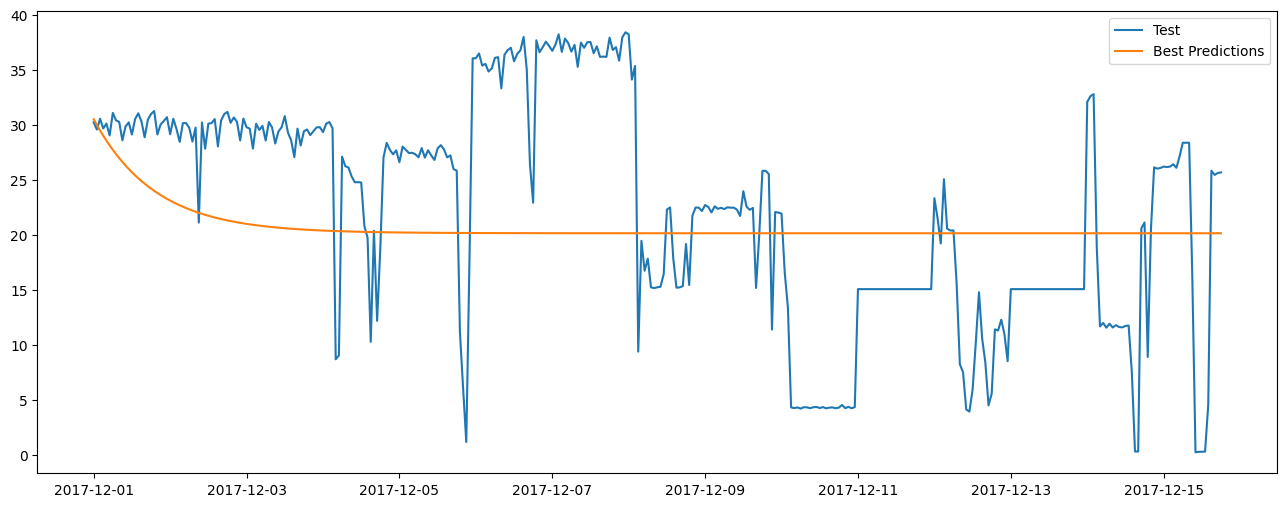

Best parameters: (1, 1, 1, 0, 0, 0)


In [55]:
from itertools import product
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the parameter grid
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s = 24  # Seasonal period

param_grid = list(product(p_values, d_values, q_values, P_values, D_values, Q_values))

best_mse = float('inf')
best_params = None

# Iterate through parameter combinations
for params in param_grid:
    p, d, q, P, D, Q = params
    model = SARIMAX(train['cpu_util'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    results = model.fit()

    # Get the predictions and calculate mean squared error
    predictions = results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    mse = np.mean((test['cpu_util'] - predictions) ** 2)

    # Check if this model has better performance
    if mse < best_mse:
        best_mse = mse
        best_params = params
        best_model = results


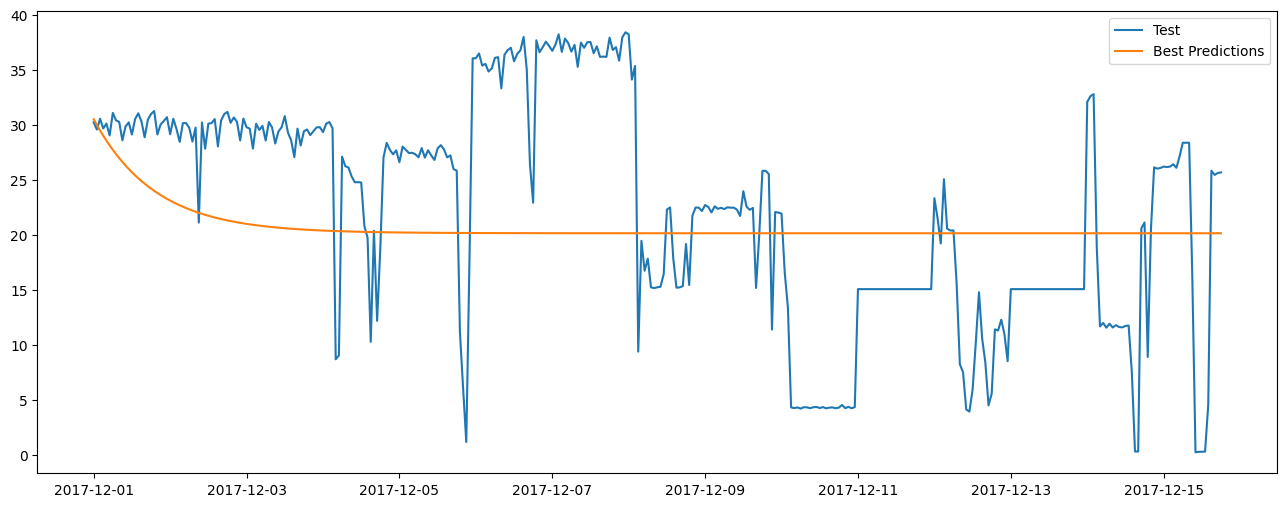

Best parameters: (1, 1, 1, 0, 0, 0)


In [56]:

# Get the best predictions
best_predictions = best_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Plot the predictions and residuals
plt.figure(figsize=(16, 6))
plt.plot(test['time'], test['cpu_util'], label='Test')
plt.plot(test['time'], best_predictions, label='Best Predictions')
plt.legend(loc='best')
plt.show()

print("Best parameters:", best_params)

## LSTM Model

cuda is enabled
Epoch: 0, loss: 0.08819
Epoch: 10, loss: 0.07361
Epoch: 20, loss: 0.06240
Epoch: 30, loss: 0.05456
Epoch: 40, loss: 0.05164
Epoch: 50, loss: 0.05203
Epoch: 60, loss: 0.05165
Epoch: 70, loss: 0.05168
Epoch: 80, loss: 0.05165
Epoch: 90, loss: 0.05164


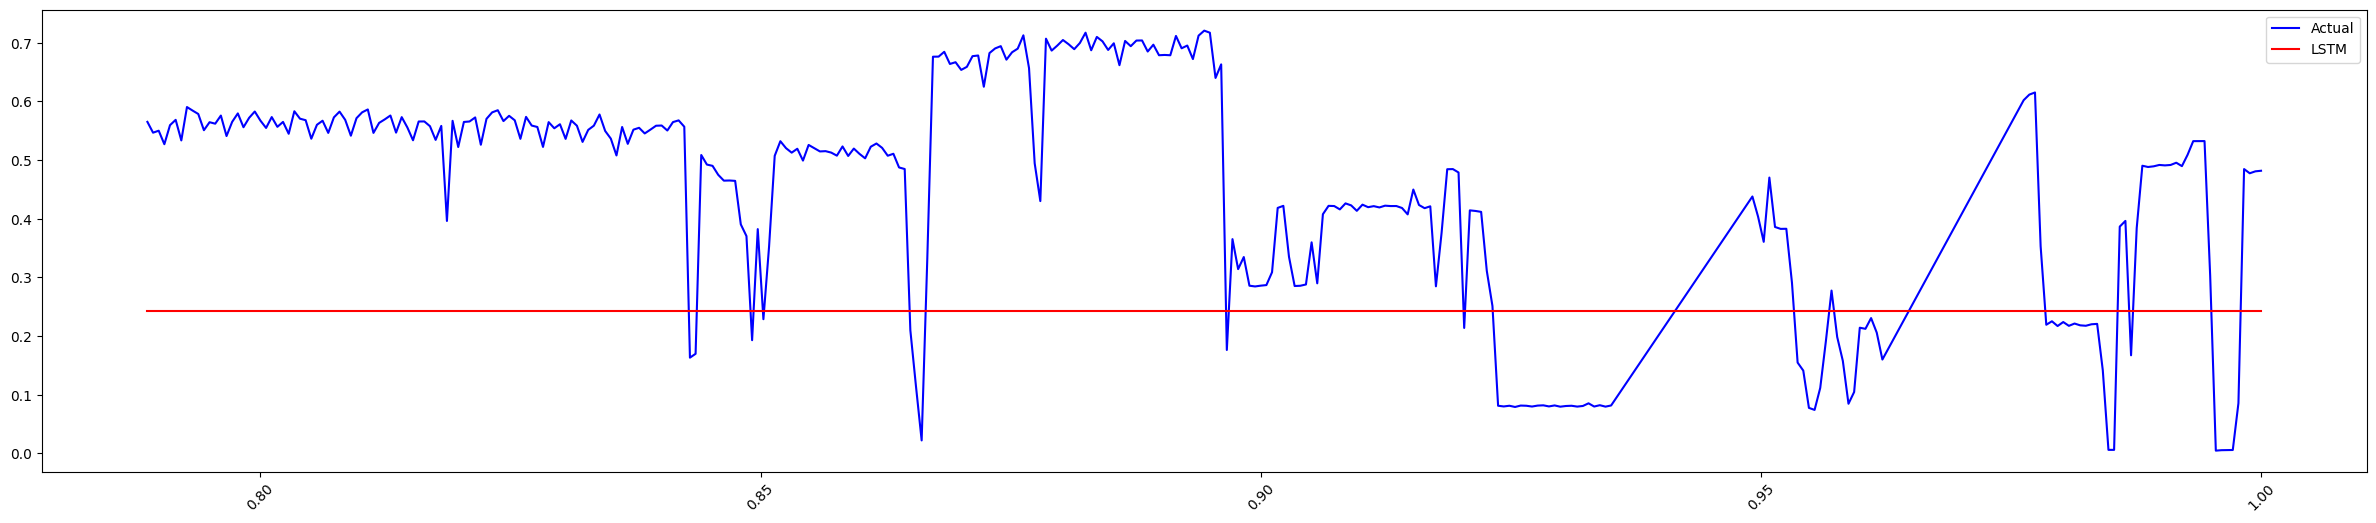

LSTM Model Metrics
Mean Squared Error: 0.078751616
Mean Absolute Error: 0.25189725
Root Mean Squared Error: 0.2806272
R-squared: -1.187669991956266
Total data length: 1633
Training data length: 1306
Test data length: 327


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing



#### DATA INGESTION ####
df = pd.read_csv('resampled_cluster_cpu_util.csv')

'''
The dataset is look like this:
time,machine_id,cpu_util
2017-11-27 00:00:00 PST,m29,31.175
2017-11-27 00:01:00 PST,m29,31.97
2017-11-27 00:02:00 PST,m29,31.711666667
2017-11-27 00:03:00 PST,m29,31.8
2017-11-27 00:04:00 PST,m29,31.845
2017-11-27 00:05:00 PST,m29,31.993333333
2017-11-27 00:06:00 PST,m29,31.16
2017-11-27 00:07:00 PST,m29,30.073333333
'''

# convert 'time' column to datetime type
df['time'] = pd.to_datetime(df['time'])

# sort the data by time
df = df.sort_values(by='time')

# normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

df['time'] = scaler_x.fit_transform(df[['time']])
df['cpu_util'] = scaler_y.fit_transform(df[['cpu_util']])


# remove null values for cpu_util or time
df = df.dropna(subset=['cpu_util', 'time'])
df_orig = df.copy()



# split the data into training and test sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]



# split the data into training and test sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]


# convert the data into PyTorch tensors
x_train = torch.FloatTensor(train_data['time'].values).unsqueeze(-1)
y_train = torch.FloatTensor(train_data['cpu_util'].values).unsqueeze(-1)

x_test = torch.FloatTensor(test_data['time'].values).unsqueeze(-1)
y_test = torch.FloatTensor(test_data['cpu_util'].values).unsqueeze(-1)

# check cuda availability
device = "cpu"

# check mps is enabled
if torch.backends.mps.is_available():
    print("MPS is enabled")
    device = "mps:0"
elif torch.cuda.is_available():
    print("cuda is enabled")
    device = "cuda"



# make training and test data on the GPU if available
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Add sequence length dimension
        x = x.unsqueeze(dim=1)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(x.device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
input_dim = 1
hidden_dim = 32
num_layers = 12
output_dim = 1
learning_rate = 0.001

# Instantiate the model
lstm_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# Move the model to the GPU if available
lstm_model.to(device)



# Define the loss function and optimizer
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)



# Train the model
epochs = 100
for epoch in range(epochs):
    outputs = lstm_model.forward(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

        
# y_hat = lstm_model(x_test).detach().numpy()
y_hat = lstm_model(x_test).detach().cpu().numpy()



# Plot the test predictions
plt.figure(figsize=(30,6))
plt.plot(x_test.cpu(), y_test.cpu(), 'b', label='Actual')
plt.plot(x_test.cpu(), y_hat, 'r', label='LSTM')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# calculate the mean squared error
lstm_mse = mean_squared_error(y_test.cpu(), y_hat)

# calculate the mean absolute error
lstm_mae = mean_absolute_error(y_test.cpu(), y_hat)

# calculate the root mean squared error
lstm_rmse = np.sqrt(lstm_mse)

# calculate the R-squared score
lstm_r2 = r2_score(y_test.cpu(), y_hat)

print("LSTM Model Metrics")
print("Mean Squared Error:", lstm_mse)
print("Mean Absolute Error:", lstm_mae)
print("Root Mean Squared Error:", lstm_rmse)
print("R-squared:", lstm_r2)

# print the length of total data, training data, and test data
print("Total data length:", len(df))
print("Training data length:", len(train_data))
print("Test data length:", len(test_data))


In [64]:
# Define a grid of hyperparameters to search
hidden_dims = [16, 32, 64, 128, 254]
learning_rates = [0.001, 0.01, 0.1, 1, 10]

best_loss = float('inf')
best_hidden_dim = None
best_learning_rate = None

for hidden_dim in hidden_dims:
    for lr in learning_rates:
        lstm_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
        lstm_model.to(device)
        optimizer = torch.optim.SGD(lstm_model.parameters(), lr=lr, momentum=0.9)

        epochs = 100
        epochs = 100
        for epoch in range(epochs):
            outputs = lstm_model.forward(x_train)
            optimizer.zero_grad()
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            if epoch % 10 == 0:
                print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
                
        y_hat = lstm_model(x_test).detach().cpu().numpy()
        outputs = lstm_model(x_test)
        loss = criterion(outputs, y_test).item()

        if loss < best_loss:
            best_loss = loss
            best_hidden_dim = hidden_dim
            best_learning_rate = lr

print("Best hidden dimension:", best_hidden_dim)
print("Best learning rate:", best_learning_rate)

Epoch: 0, loss: 0.15152
Epoch: 10, loss: 0.13517
Epoch: 20, loss: 0.10957
Epoch: 30, loss: 0.08829
Epoch: 40, loss: 0.07370
Epoch: 50, loss: 0.06454
Epoch: 60, loss: 0.05905
Epoch: 70, loss: 0.05586
Epoch: 80, loss: 0.05402
Epoch: 90, loss: 0.05298
Epoch: 0, loss: 0.07234
Epoch: 10, loss: 0.05313
Epoch: 20, loss: 0.05347
Epoch: 30, loss: 0.05211
Epoch: 40, loss: 0.05176
Epoch: 50, loss: 0.05174
Epoch: 60, loss: 0.05165
Epoch: 70, loss: 0.05166
Epoch: 80, loss: 0.05164
Epoch: 90, loss: 0.05164
Epoch: 0, loss: 0.14216
Epoch: 10, loss: 0.05284
Epoch: 20, loss: 0.06214
Epoch: 30, loss: 0.05195
Epoch: 40, loss: 0.05286
Epoch: 50, loss: 0.05170
Epoch: 60, loss: 0.05178
Epoch: 70, loss: 0.05165
Epoch: 80, loss: 0.05166
Epoch: 90, loss: 0.05164
Epoch: 0, loss: 0.09046
Epoch: 10, loss: 0.06091
Epoch: 20, loss: 0.06134
Epoch: 30, loss: 0.05403
Epoch: 40, loss: 0.05180
Epoch: 50, loss: 0.05167
Epoch: 60, loss: 0.05172
Epoch: 70, loss: 0.05169
Epoch: 80, loss: 0.05166
Epoch: 90, loss: 0.05164
Epoc

Epoch: 0, loss: 0.11361
Epoch: 10, loss: 0.05322
Epoch: 20, loss: 0.05816
Epoch: 30, loss: 0.05227
Epoch: 40, loss: 0.05226
Epoch: 50, loss: 0.05179
Epoch: 60, loss: 0.05169
Epoch: 70, loss: 0.05167
Epoch: 80, loss: 0.05165
Epoch: 90, loss: 0.05165


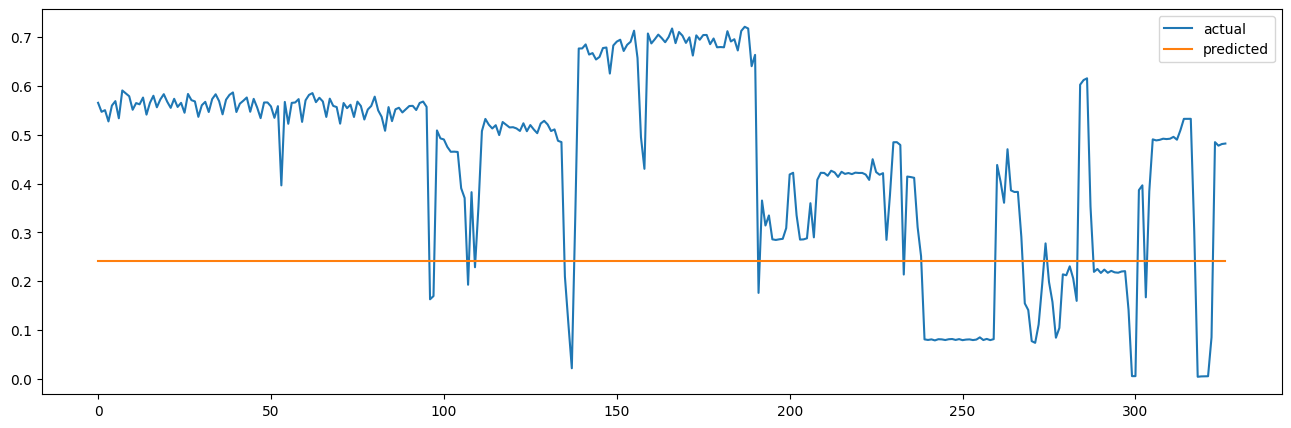

In [65]:

# plot the best model
lstm_model = LSTMModel(input_dim, best_hidden_dim, num_layers, output_dim)
lstm_model.to(device)
optimizer = torch.optim.SGD(lstm_model.parameters(), lr=best_learning_rate, momentum=0.9)

epochs = 100
for epoch in range(epochs):
    outputs = lstm_model.forward(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

y_hat = lstm_model(x_test).detach().cpu().numpy()
outputs = lstm_model(x_test)
loss = criterion(outputs, y_test).item()

plt.figure(figsize=(16,5))
plt.plot(y_test.cpu(), label='actual')
plt.plot(y_hat, label='predicted')
plt.legend()
plt.show()

### Feature Engineering

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from torch.utils.data import DataLoader, TensorDataset



#### DATA INGESTION ####
df = pd.read_csv('resampled_cluster_cpu_util.csv')

'''
The dataset is look like this:
time,machine_id,cpu_util
2017-11-27 00:00:00 PST,m29,31.175
2017-11-27 00:01:00 PST,m29,31.97
2017-11-27 00:02:00 PST,m29,31.711666667
2017-11-27 00:03:00 PST,m29,31.8
2017-11-27 00:04:00 PST,m29,31.845
2017-11-27 00:05:00 PST,m29,31.993333333
2017-11-27 00:06:00 PST,m29,31.16
2017-11-27 00:07:00 PST,m29,30.073333333
'''

# convert 'time' column to datetime type
df['time'] = pd.to_datetime(df['time'])

# sort the data by time
df = df.sort_values(by='time')


### Feature Engineering ###
# time based features
df['hour'] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek
df['dayofmonth'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year

# machine_id based features
df['machine_id'] = df['machine_id'].astype('category')

# one-hot encoding
df = pd.get_dummies(df, columns=['machine_id'])

# Lagged Features
df['cpu_util_lag1'] = df['cpu_util'].shift(1)
df['cpu_util_lag2'] = df['cpu_util'].shift(2)
df['cpu_util_lag3'] = df['cpu_util'].shift(3)
df['cpu_util_lag4'] = df['cpu_util'].shift(4)

# Moving Average Features
df['cpu_util_ma4'] = df['cpu_util'].rolling(window=4).mean()
df['cpu_util_ma8'] = df['cpu_util'].rolling(window=8).mean()
df['cpu_util_ma12'] = df['cpu_util'].rolling(window=12).mean()
df['cpu_util_ma16'] = df['cpu_util'].rolling(window=16).mean()

# Change Features
df['cpu_util_change1'] = df['cpu_util'].diff(1)
df['cpu_util_change2'] = df['cpu_util'].diff(2)
df['cpu_util_change3'] = df['cpu_util'].diff(3)
df['cpu_util_change4'] = df['cpu_util'].diff(4)

# EMA (Exponential Moving Average)
df['cpu_util_ema4'] = df['cpu_util'].ewm(span=4, adjust=False).mean()
df['cpu_util_ema8'] = df['cpu_util'].ewm(span=8, adjust=False).mean()
df['cpu_util_ema12'] = df['cpu_util'].ewm(span=12, adjust=False).mean()
df['cpu_util_ema16'] = df['cpu_util'].ewm(span=16, adjust=False).mean()


#drop the null values
df = df.dropna()

df_copy = df.copy()
# drop the 'time' column
df = df.drop(columns=['time'])

#### Scaling ######
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)

X = df_scaled.drop(columns=['cpu_util']).values
y = df_scaled['cpu_util'].values

#### LSTM MODEL ####
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)  # Get batch size
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)  # Initialize cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = df_scaled.shape[1] - 1  # Exclude the target column
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 64

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Training loop ###
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
df_tensor = torch.tensor(df_scaled.values, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(df_tensor), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch[0].to(device)
        inputs = batch[:, :-1].unsqueeze(1)
        targets = batch[:, -1]
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        
        # Apply gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

### Evaluation ###
model.eval()
with torch.no_grad():
    predictions = []
    for i in range(len(df_scaled) - input_size):
        input_seq = df_tensor[i:i+input_size, :-1].unsqueeze(0)
        prediction = model(input_seq).item()
        predictions.append(prediction)

    

Epoch [1/50], Loss: 1.6451
Epoch [2/50], Loss: 0.5391
Epoch [3/50], Loss: 0.1221
Epoch [4/50], Loss: 0.0539
Epoch [5/50], Loss: 0.0437
Epoch [6/50], Loss: 0.0375
Epoch [7/50], Loss: 0.0335
Epoch [8/50], Loss: 0.0304
Epoch [9/50], Loss: 0.0278
Epoch [10/50], Loss: 0.0252
Epoch [11/50], Loss: 0.0234
Epoch [12/50], Loss: 0.0214
Epoch [13/50], Loss: 0.0197
Epoch [14/50], Loss: 0.0178
Epoch [15/50], Loss: 0.0162
Epoch [16/50], Loss: 0.0145
Epoch [17/50], Loss: 0.0135
Epoch [18/50], Loss: 0.0121
Epoch [19/50], Loss: 0.0102
Epoch [20/50], Loss: 0.0090
Epoch [21/50], Loss: 0.0079
Epoch [22/50], Loss: 0.0071
Epoch [23/50], Loss: 0.0064
Epoch [24/50], Loss: 0.0058
Epoch [25/50], Loss: 0.0057
Epoch [26/50], Loss: 0.0051
Epoch [27/50], Loss: 0.0053
Epoch [28/50], Loss: 0.0049
Epoch [29/50], Loss: 0.0046
Epoch [30/50], Loss: 0.0045
Epoch [31/50], Loss: 0.0046
Epoch [32/50], Loss: 0.0042
Epoch [33/50], Loss: 0.0041
Epoch [34/50], Loss: 0.0042
Epoch [35/50], Loss: 0.0041
Epoch [36/50], Loss: 0.0041
E

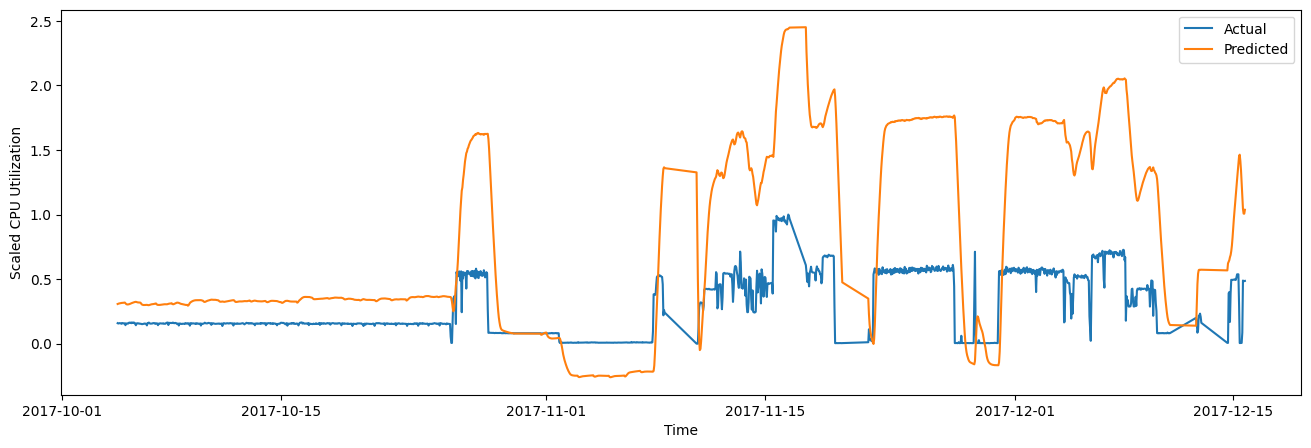

In [88]:
# Plotting
plt.figure(figsize=(16,5))
plt.plot(df_copy['time'][input_size:], df_scaled['cpu_util'][input_size:], label='Actual')
plt.plot(df_copy['time'][input_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Scaled CPU Utilization')
plt.legend()
plt.show()

In [72]:
from itertools import product

# Define the ranges of values for hyperparameters
hidden_size_values = [32, 64, 128]
num_layers_values = [1, 2, 3]
learning_rate_values = [0.001, 0.01, 0.1]
num_epochs_values = [50, 100, 150, 200, 250]
batch_size_values = [32, 64, 128]

# Initialize best hyperparameters and best score
best_hyperparameters = {}
best_score = float('inf')

# Generate combinations of hyperparameters
hyperparameter_combinations = product(
    hidden_size_values, num_layers_values, learning_rate_values,
    num_epochs_values, batch_size_values
)

# Iterate through combinations
for hyperparameters in tqdm(hyperparameter_combinations, total=len(hidden_size_values) * len(num_layers_values) * len(learning_rate_values) * len(num_epochs_values) * len(batch_size_values)):
    hidden_size, num_layers, learning_rate, num_epochs, batch_size = hyperparameters
#     print("Current hyperparameters:", hyperparameters)


    # Create the model with the current hyperparameters
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move the model to the appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Convert data to tensor and set up DataLoader
    df_tensor = torch.tensor(df_scaled.values, dtype=torch.float32).to(device)
    train_loader = DataLoader(TensorDataset(df_tensor), batch_size=batch_size, shuffle=True)

    # Training loop
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch[0].to(device)
            inputs = batch[:, :-1].unsqueeze(1)
            targets = batch[:, -1]
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            # Apply gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()
            total_loss += loss.item()

#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = []
        for i in range(len(df_scaled) - input_size):
            input_seq = df_tensor[i:i+input_size, :-1].unsqueeze(0)
            prediction = model(input_seq).item()
            predictions.append(prediction)

    # Compare the performance and update if better
    validation_targets = df_scaled['cpu_util'][input_size:]
    if mean_squared_error(validation_targets, predictions) < best_score:
        best_score = mean_squared_error(validation_targets, predictions)
        best_hyperparameters = {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'batch_size': batch_size
        }

# Print the best hyperparameters
print("Best hyperparameters:", best_hyperparameters)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 405/405 [1:29:48<00:00, 13.31s/it]

Best hyperparameters: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.1, 'num_epochs': 150, 'batch_size': 32}


In [90]:
# plot best model
model = LSTMModel(input_size, best_hyperparameters['hidden_size'], best_hyperparameters['num_layers'], output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_hyperparameters['learning_rate'])

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Convert data to tensor and set up DataLoader
df_tensor = torch.tensor(df_scaled.values, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(df_tensor), batch_size=best_hyperparameters['batch_size'], shuffle=True)

# Training loop
for epoch in range(best_hyperparameters['num_epochs']):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch[0].to(device)
        inputs = batch[:, :-1].unsqueeze(1)
        targets = batch[:, -1]
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()

        # Apply gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{best_hyperparameters['num_epochs']}], Loss: {total_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    predictions = []
    for i in range(len(df_scaled) - input_size):
        input_seq = df_tensor[i:i+input_size, :-1].unsqueeze(0)
        prediction = model(input_seq).item()
        predictions.append(prediction)
   

Epoch [1/150], Loss: 6.5288
Epoch [2/150], Loss: 0.2871
Epoch [3/150], Loss: 0.1294
Epoch [4/150], Loss: 0.0409
Epoch [5/150], Loss: 0.0680
Epoch [6/150], Loss: 0.0246
Epoch [7/150], Loss: 0.0132
Epoch [8/150], Loss: 0.0158
Epoch [9/150], Loss: 0.0243
Epoch [10/150], Loss: 0.0206
Epoch [11/150], Loss: 0.0240
Epoch [12/150], Loss: 0.0259
Epoch [13/150], Loss: 0.0229
Epoch [14/150], Loss: 0.0100
Epoch [15/150], Loss: 0.0150
Epoch [16/150], Loss: 0.0154
Epoch [17/150], Loss: 0.0162
Epoch [18/150], Loss: 0.0155
Epoch [19/150], Loss: 0.0173
Epoch [20/150], Loss: 0.0141
Epoch [21/150], Loss: 0.0112
Epoch [22/150], Loss: 0.0221
Epoch [23/150], Loss: 0.0268
Epoch [24/150], Loss: 0.0168
Epoch [25/150], Loss: 0.0233
Epoch [26/150], Loss: 0.0317
Epoch [27/150], Loss: 0.0117
Epoch [28/150], Loss: 0.0092
Epoch [29/150], Loss: 0.0134
Epoch [30/150], Loss: 0.0171
Epoch [31/150], Loss: 0.0190
Epoch [32/150], Loss: 0.0157
Epoch [33/150], Loss: 0.0112
Epoch [34/150], Loss: 0.0096
Epoch [35/150], Loss: 0

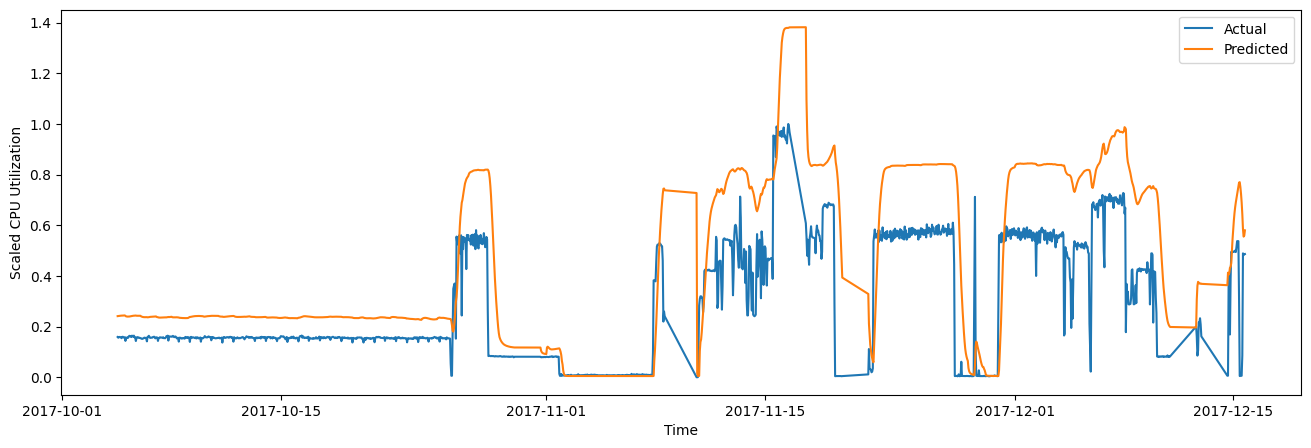

In [91]:
# Plotting
plt.figure(figsize=(16,5))
plt.plot(df_copy['time'][input_size:], df_scaled['cpu_util'][input_size:], label='Actual')
plt.plot(df_copy['time'][input_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Scaled CPU Utilization')
plt.legend()
plt.show()

In [95]:
print('Mean Absolute Percentage Error: ', mean_absolute_percentage_error(df_scaled['cpu_util'][input_size:], predictions))
print('Mean Squared Error: ', mean_squared_error(df_scaled['cpu_util'][input_size:], predictions, squared=False))
print('Mean Absolute Error: ', mean_absolute_error(df_scaled['cpu_util'][input_size:], predictions))


Mean Absolute Percentage Error:  2235656518356.4985
Mean Squared Error:  0.23303531306707564
Mean Absolute Error:  0.17364826081930357


/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ec22163/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


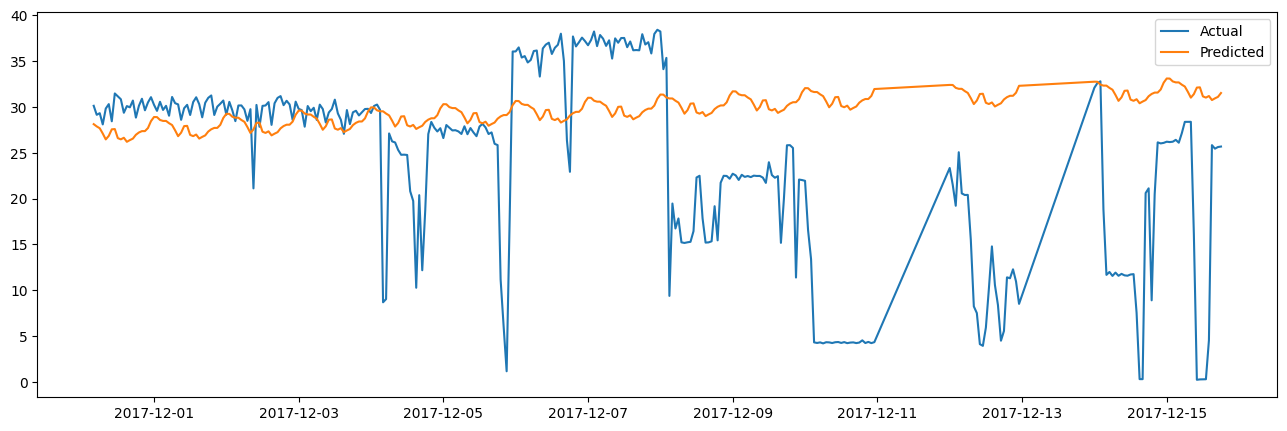

Mean Absolute Percentage Error: 2.885
Root Mean Squared Error: 12.238
Mean Absolute Error: 8.856


In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from torch.utils.data import DataLoader, TensorDataset



#### DATA INGESTION ####
df = pd.read_csv('resampled_cluster_cpu_util.csv')

# convert 'time' column to datetime type
df['time'] = pd.to_datetime(df['time'])

# sort the data by time
df = df.sort_values(by='time')

# remove the null values
df = df.dropna()

# split the data into training and testing 80/20
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# create model
model  = ExponentialSmoothing(train['cpu_util'], trend='add', seasonal='add', seasonal_periods=24)

# fit model
model_fit = model.fit()

# Reset the index of the test DataFrame for prediction
test_reset_index = test.reset_index(drop=True)

# Make prediction
yhat = model_fit.predict(start=len(train), end=len(train) + len(test_reset_index) - 1)

# Plot
plt.figure(figsize=(16, 5))
plt.plot(test_reset_index['time'], test_reset_index['cpu_util'], label='Actual')
plt.plot(test_reset_index['time'], yhat, label='Predicted')
plt.legend()
plt.show()



# calculate the mean absolute percentage error (MAPE)
mape = mean_absolute_percentage_error(test['cpu_util'], yhat)
print('Mean Absolute Percentage Error: %.3f' % mape)

# calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(test['cpu_util'], yhat))
print('Root Mean Squared Error: %.3f' % rmse)

# calculate the mean absolute error (MAE)
mae = mean_absolute_error(test['cpu_util'], yhat)
print('Mean Absolute Error: %.3f' % mae)
